In [315]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
# Control warnings
import warnings; warnings.simplefilter('ignore')

import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

import torch
import anndata
from tqdm import tqdm
from umap import UMAP
from openTSNE import TSNE
import scanpy as sc 
import plotly.express as px
import plotly.graph_objects as go
from IPython.display import Image
import scvi
print('You are using scvi-tools version:',scvi.__version__)


from matplotlib import cm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import itertools

You are using scvi-tools version: 0.13.0


In [316]:
# downloads a file that maps gene names to gene id and puts that in a dataframe
# the genemaps is used to add the gene names
!wget -nc https://raw.githubusercontent.com/Munfred/worm-markers/master/worm_gene_name_id.csv
genemaps = pd.read_csv('./worm_gene_name_id.csv', index_col=1)
name2id=genemaps.set_index('gene_name')
name2id['gene_id']=genemaps.index


File ‘worm_gene_name_id.csv’ already there; not retrieving.



ASEL


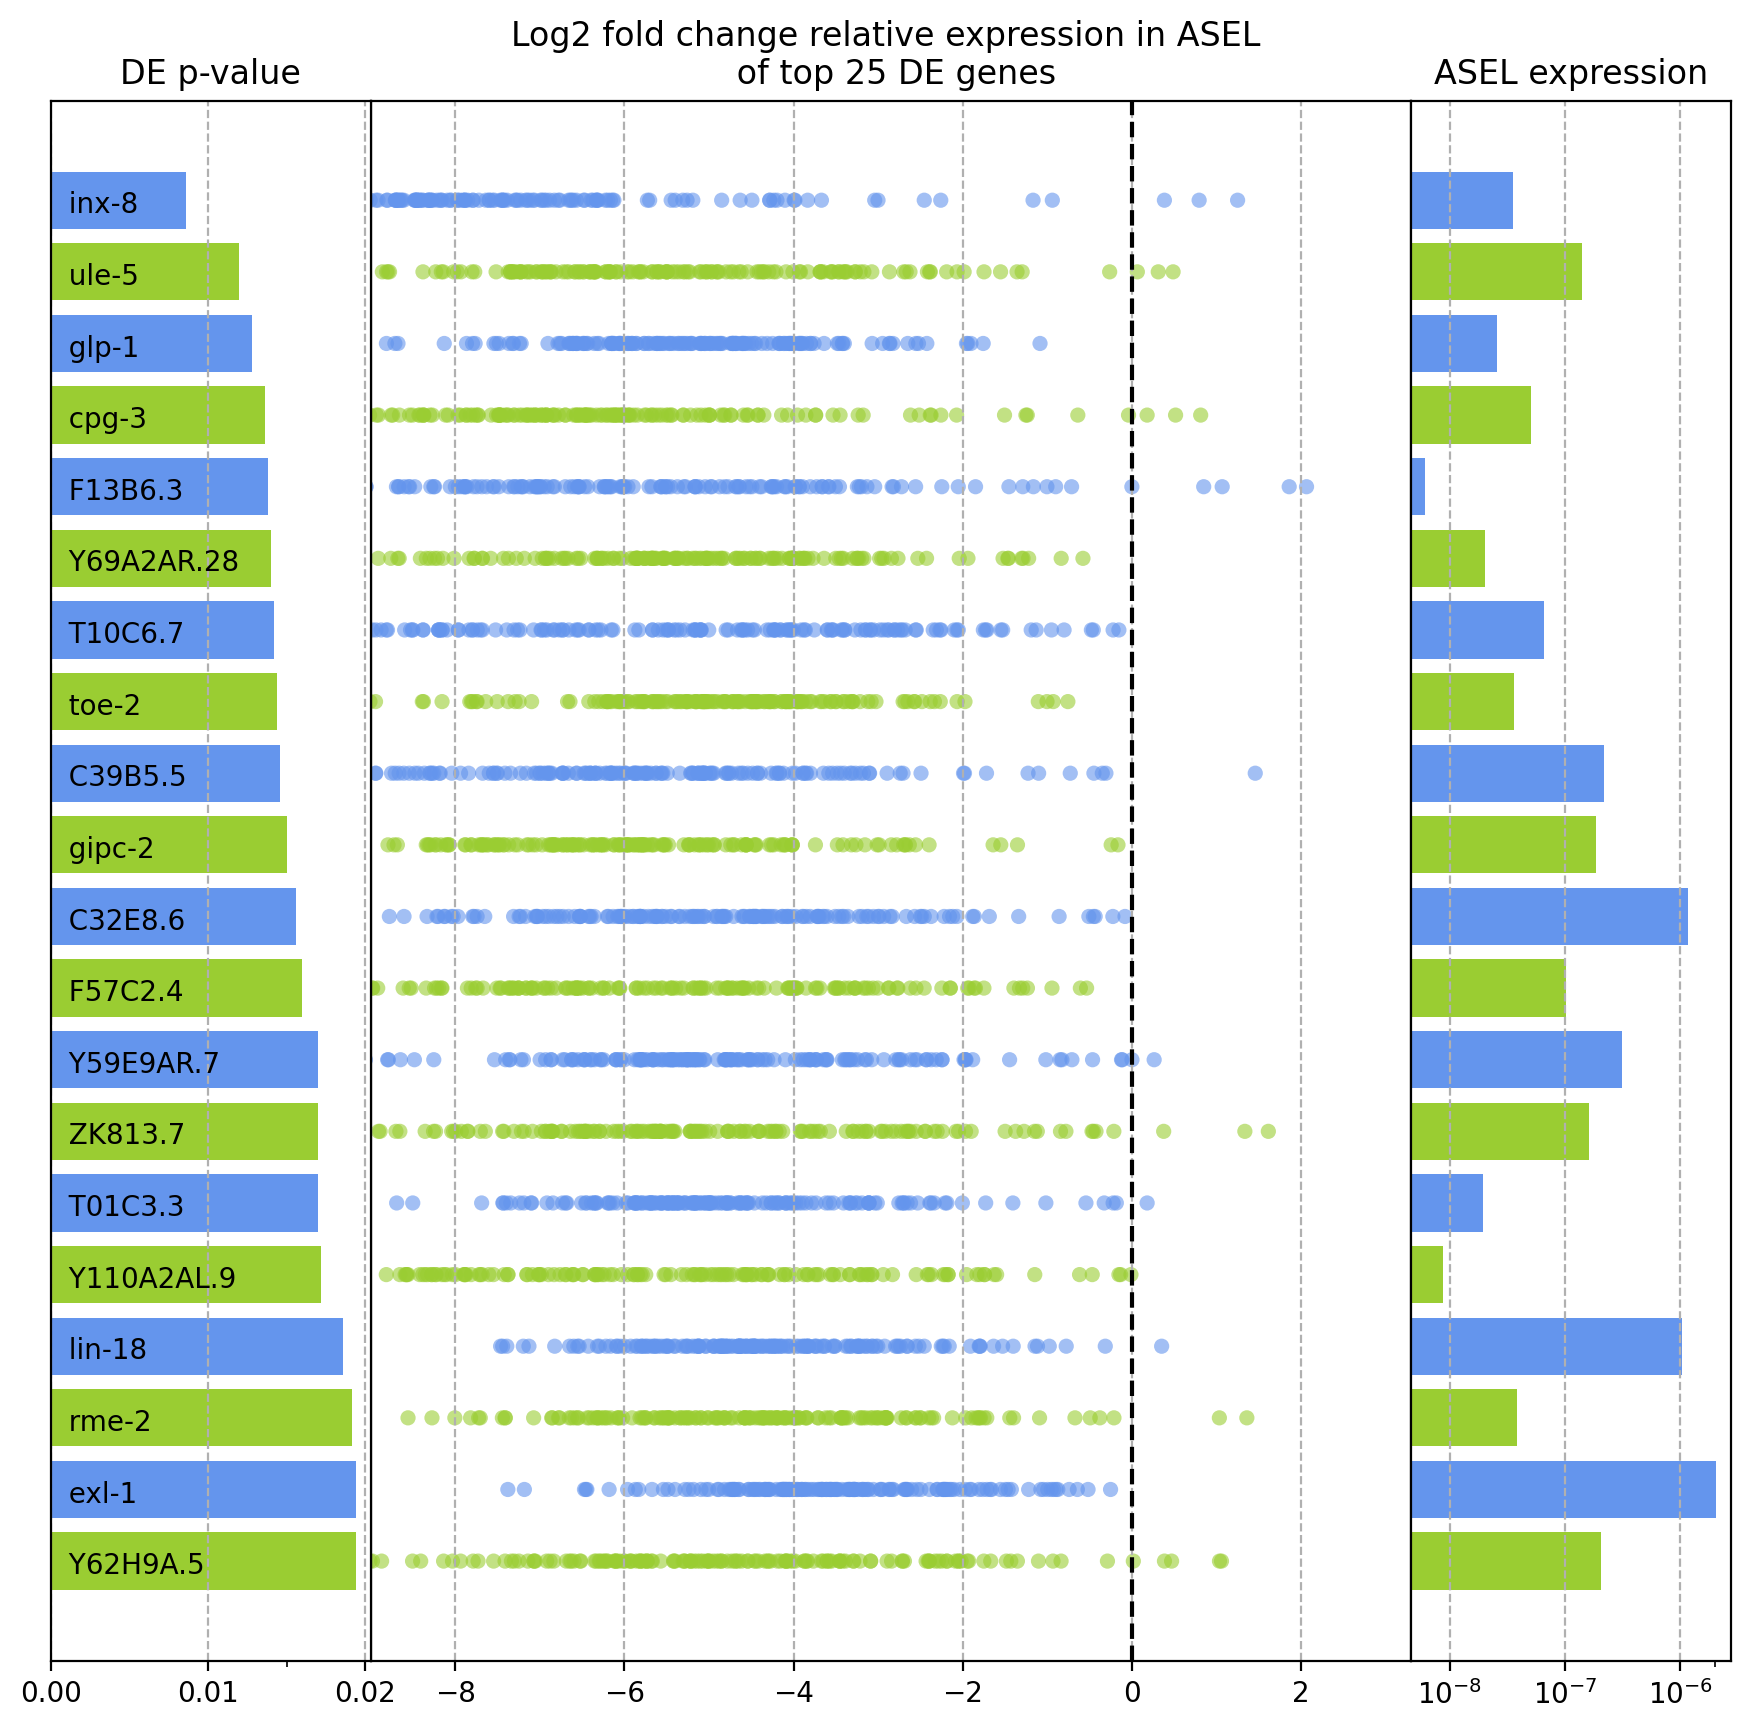

ASER


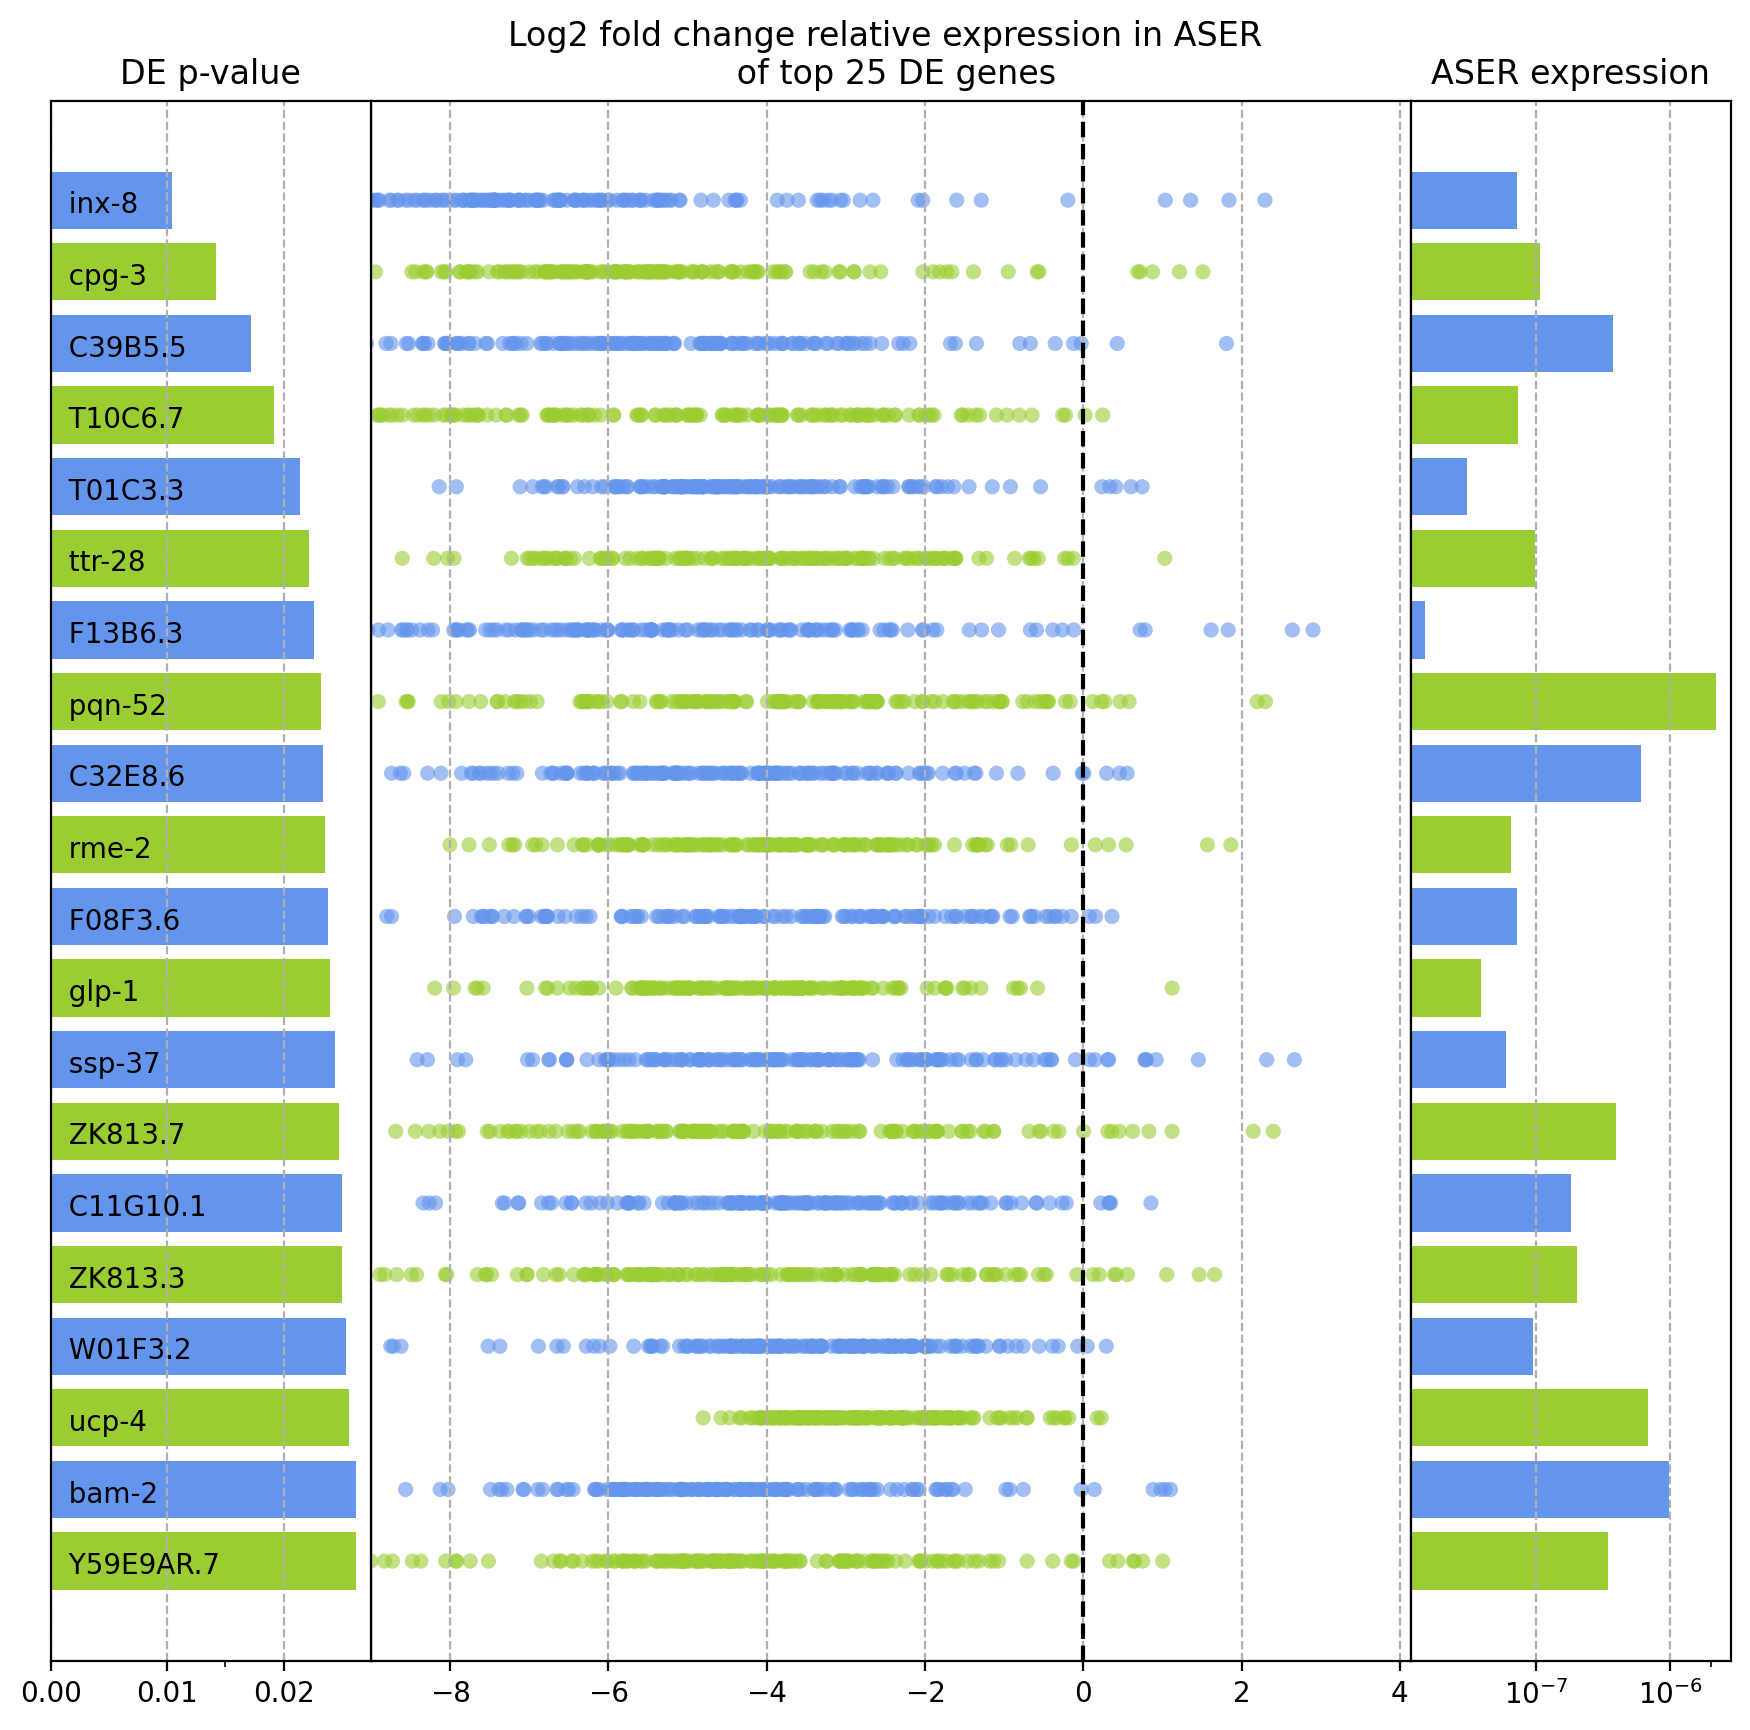

ASG


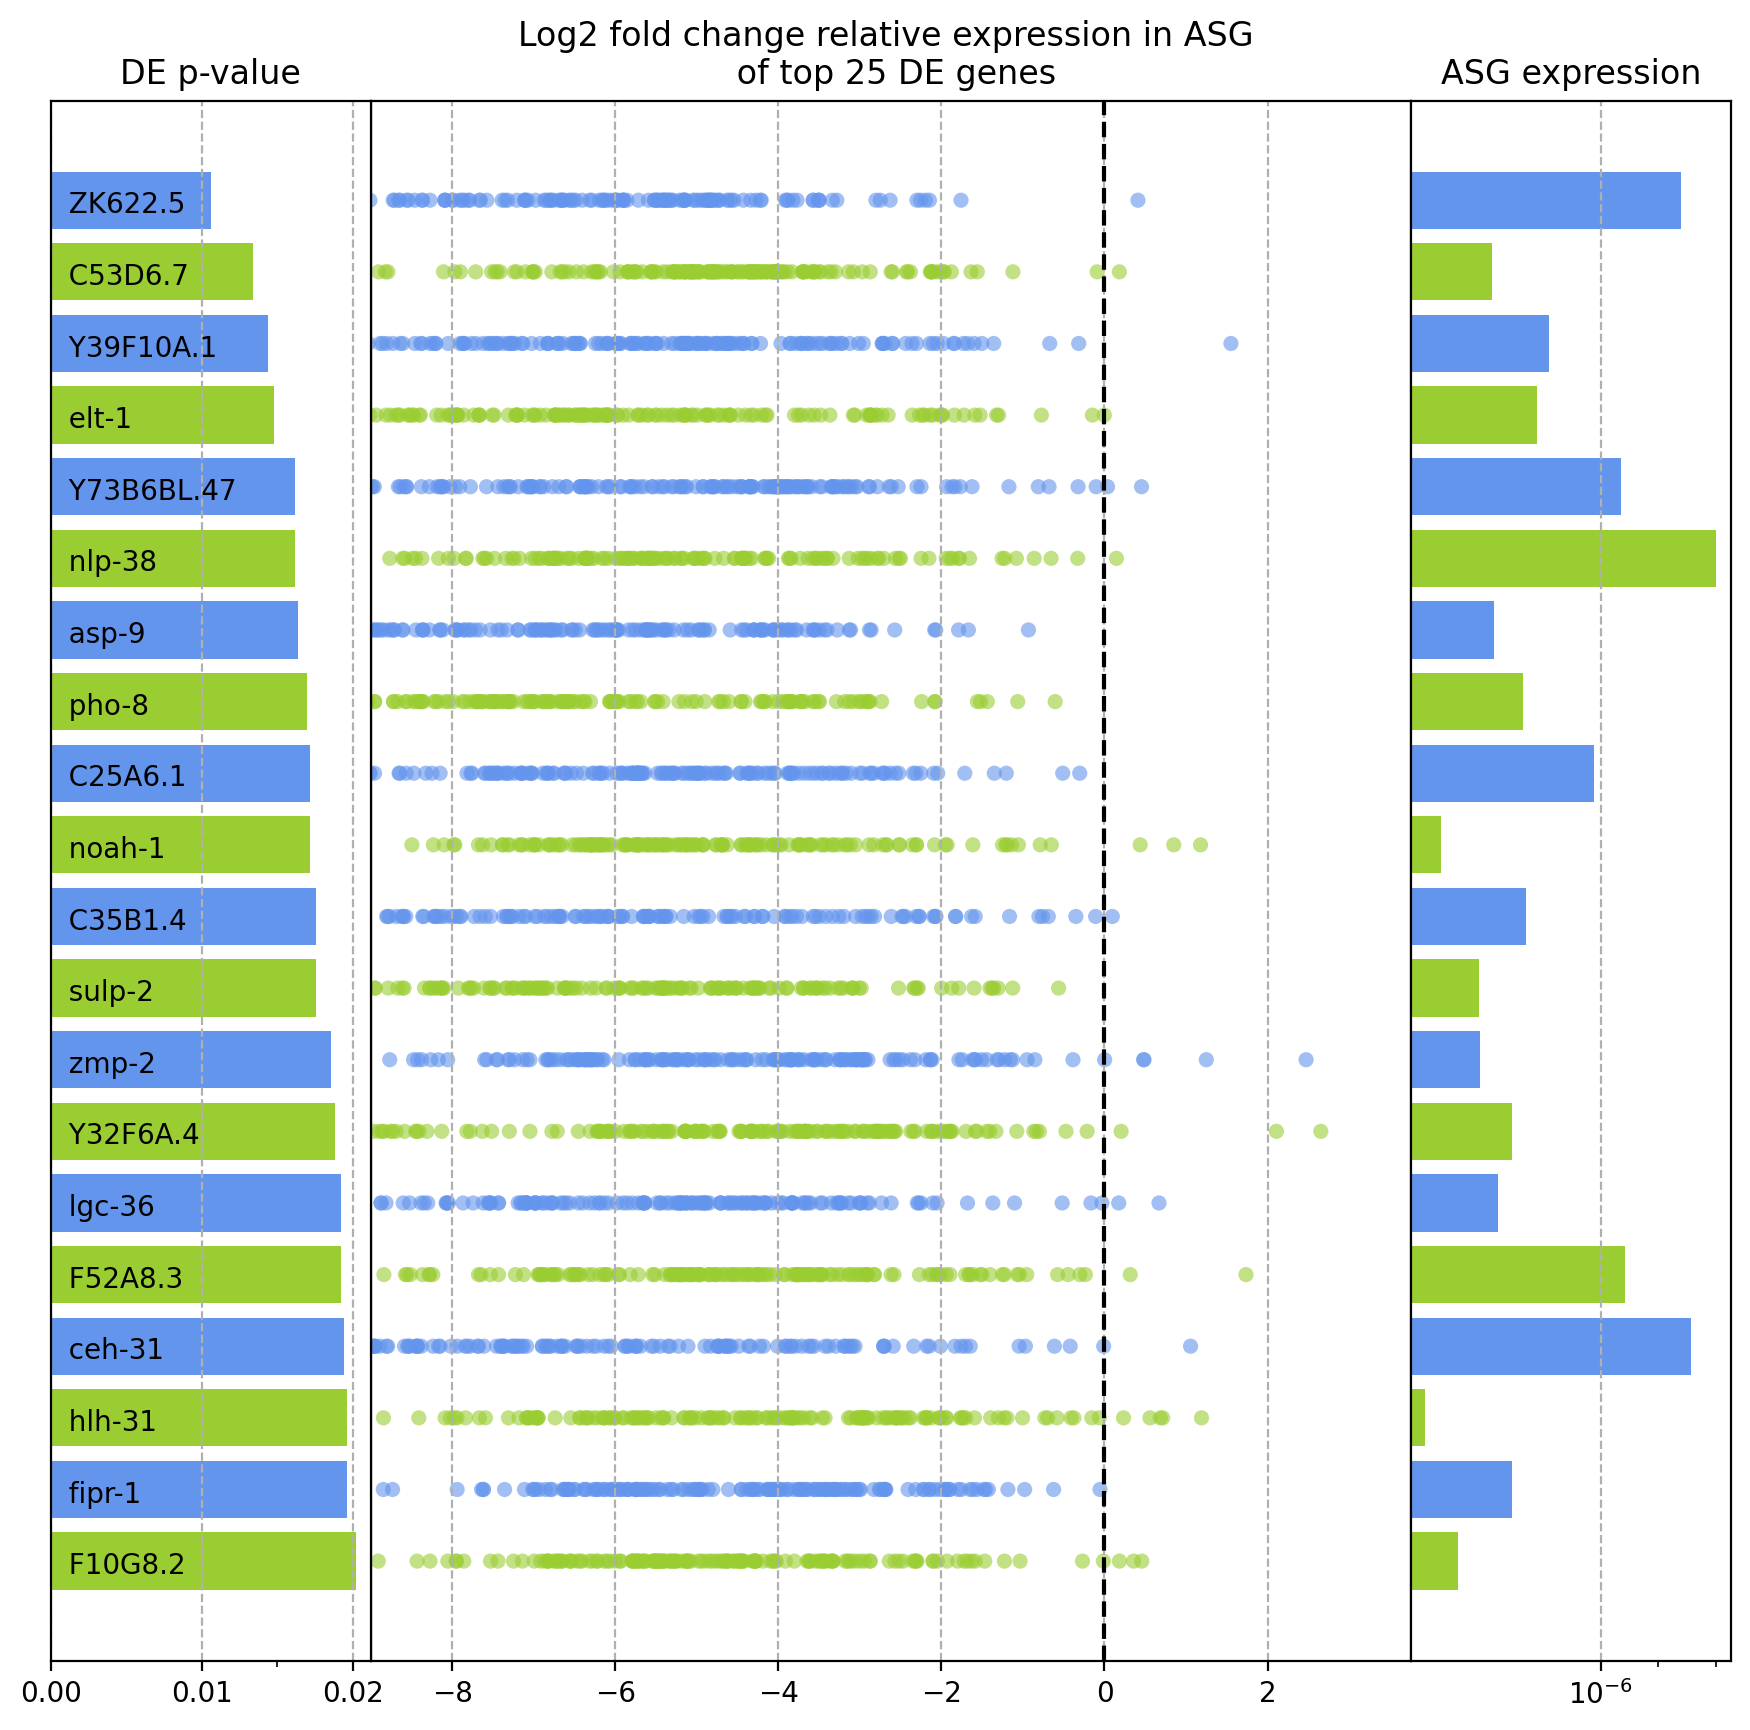

ASH


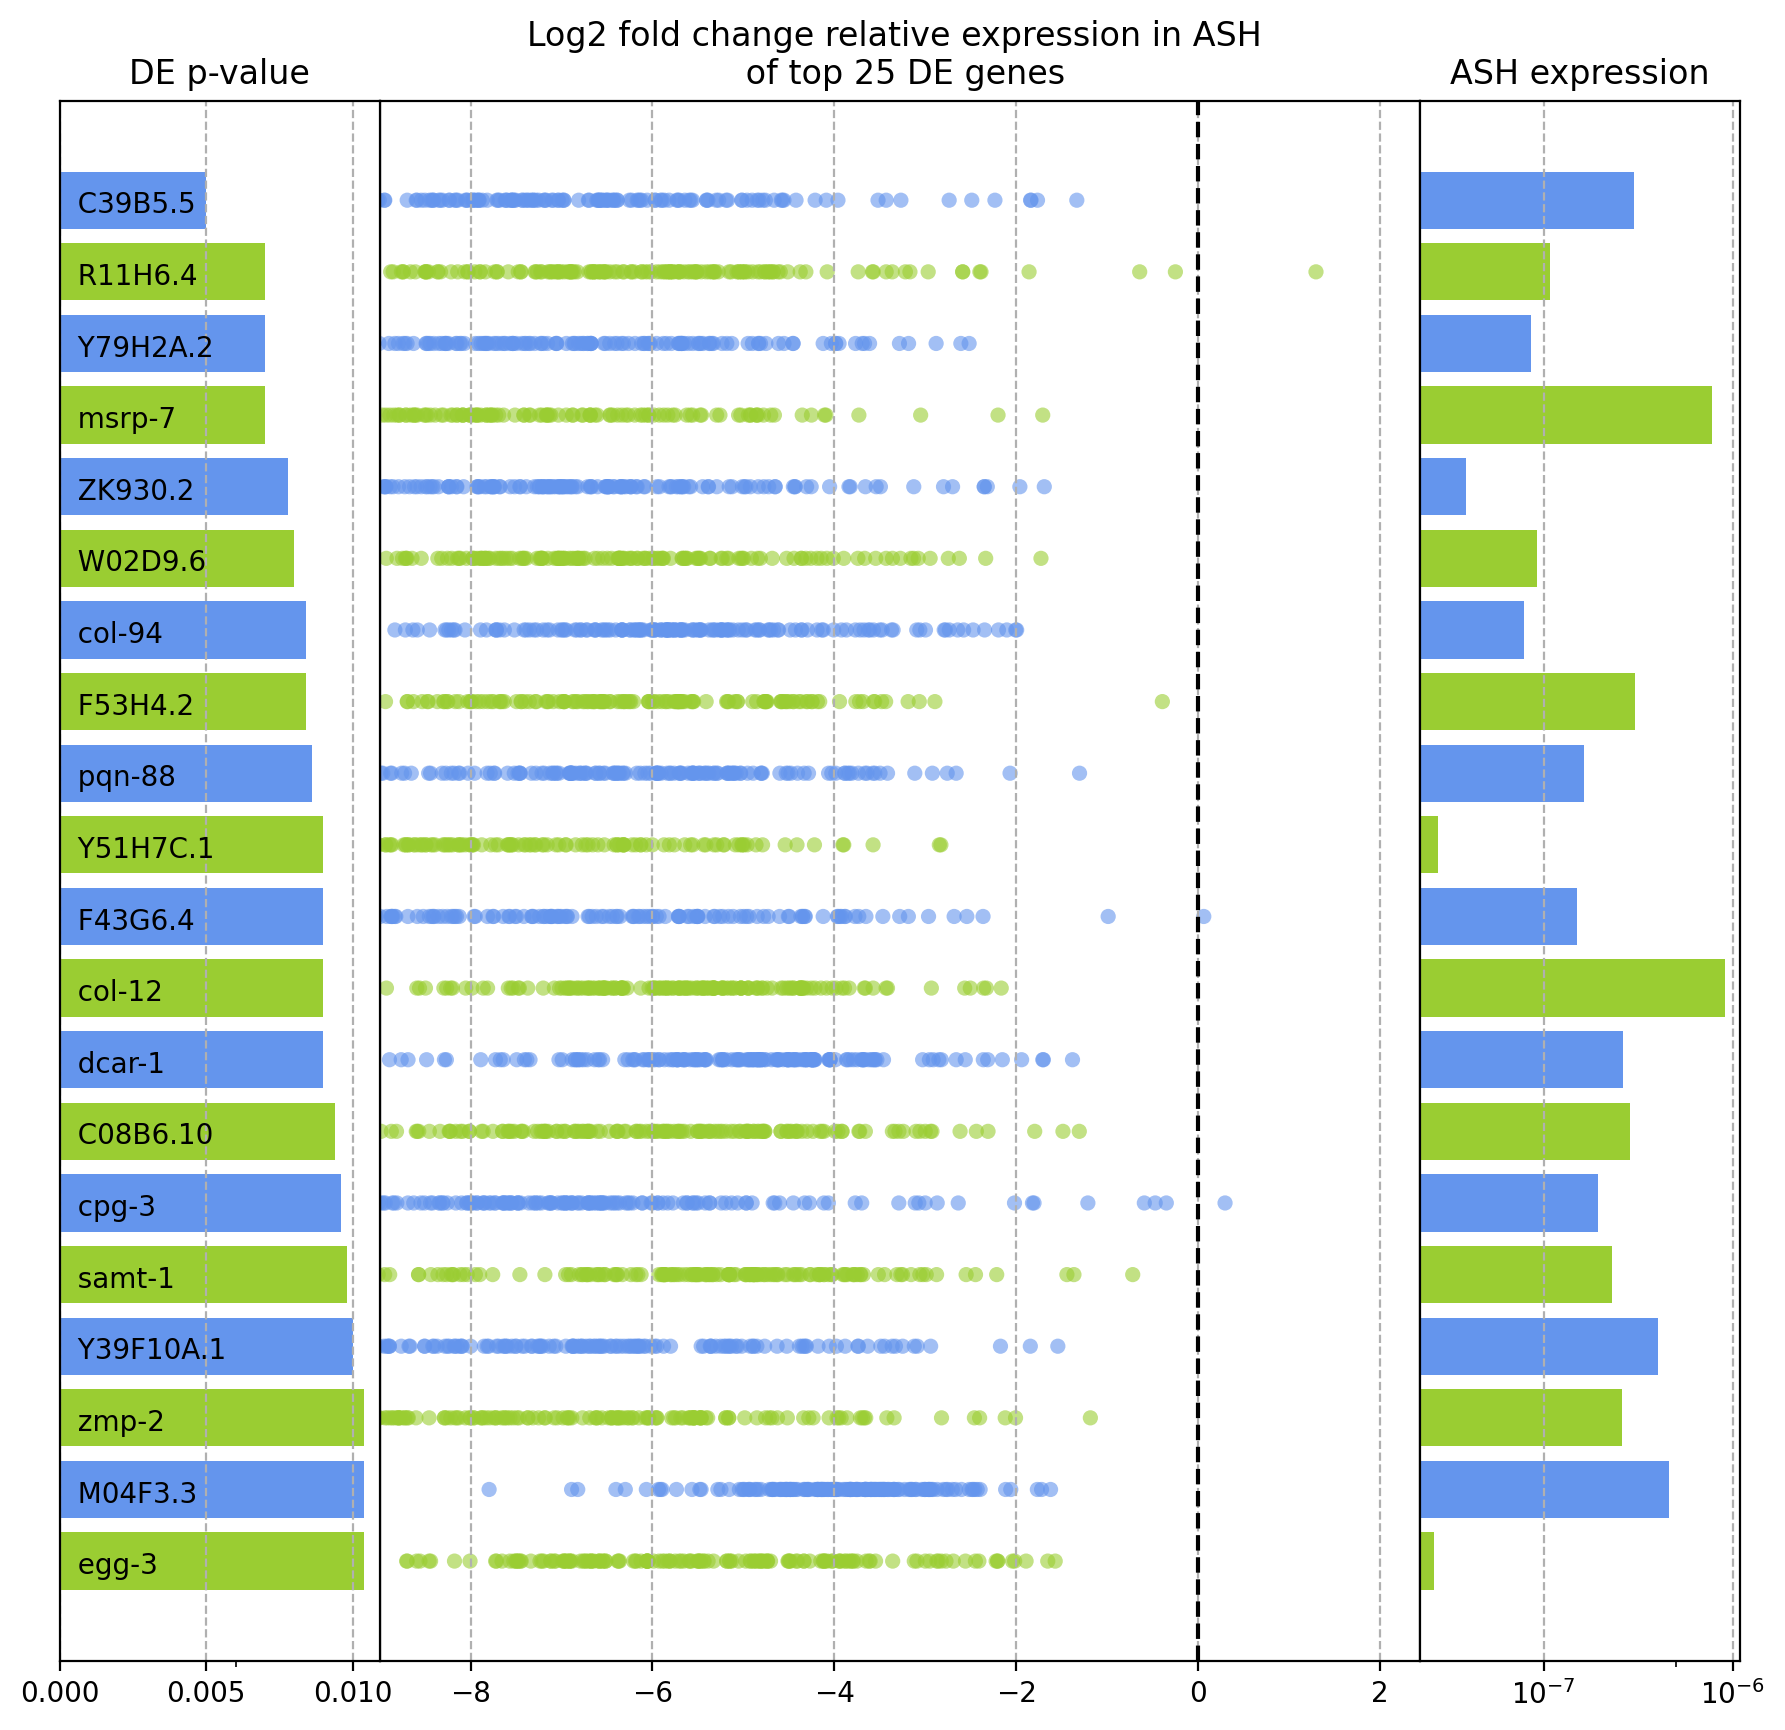

ASI


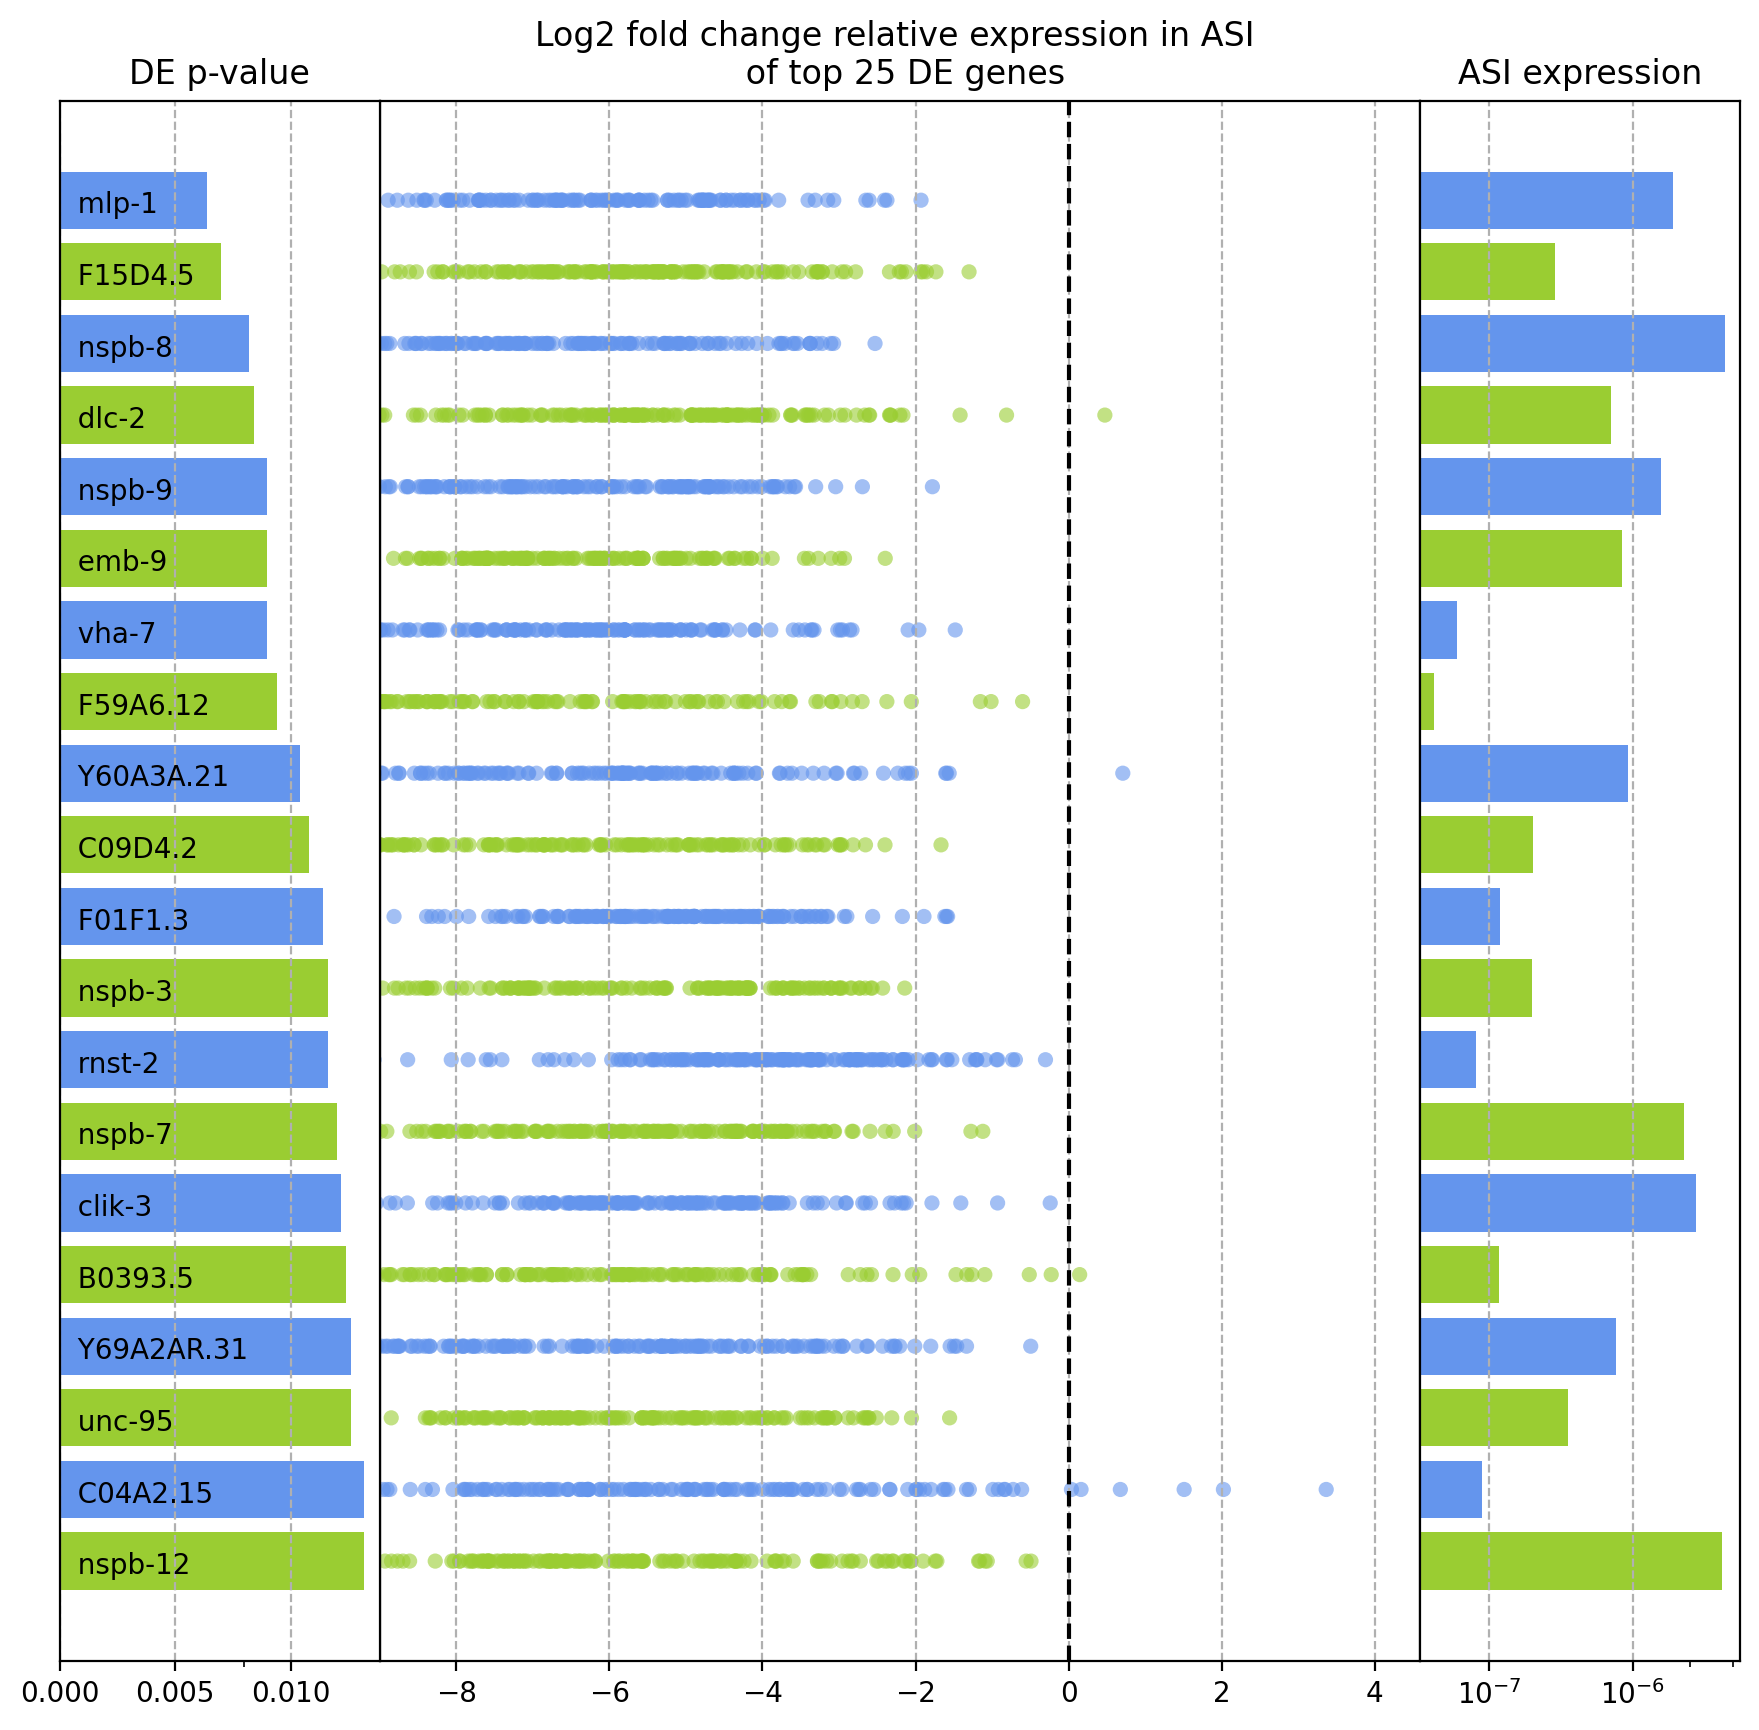

ASJ


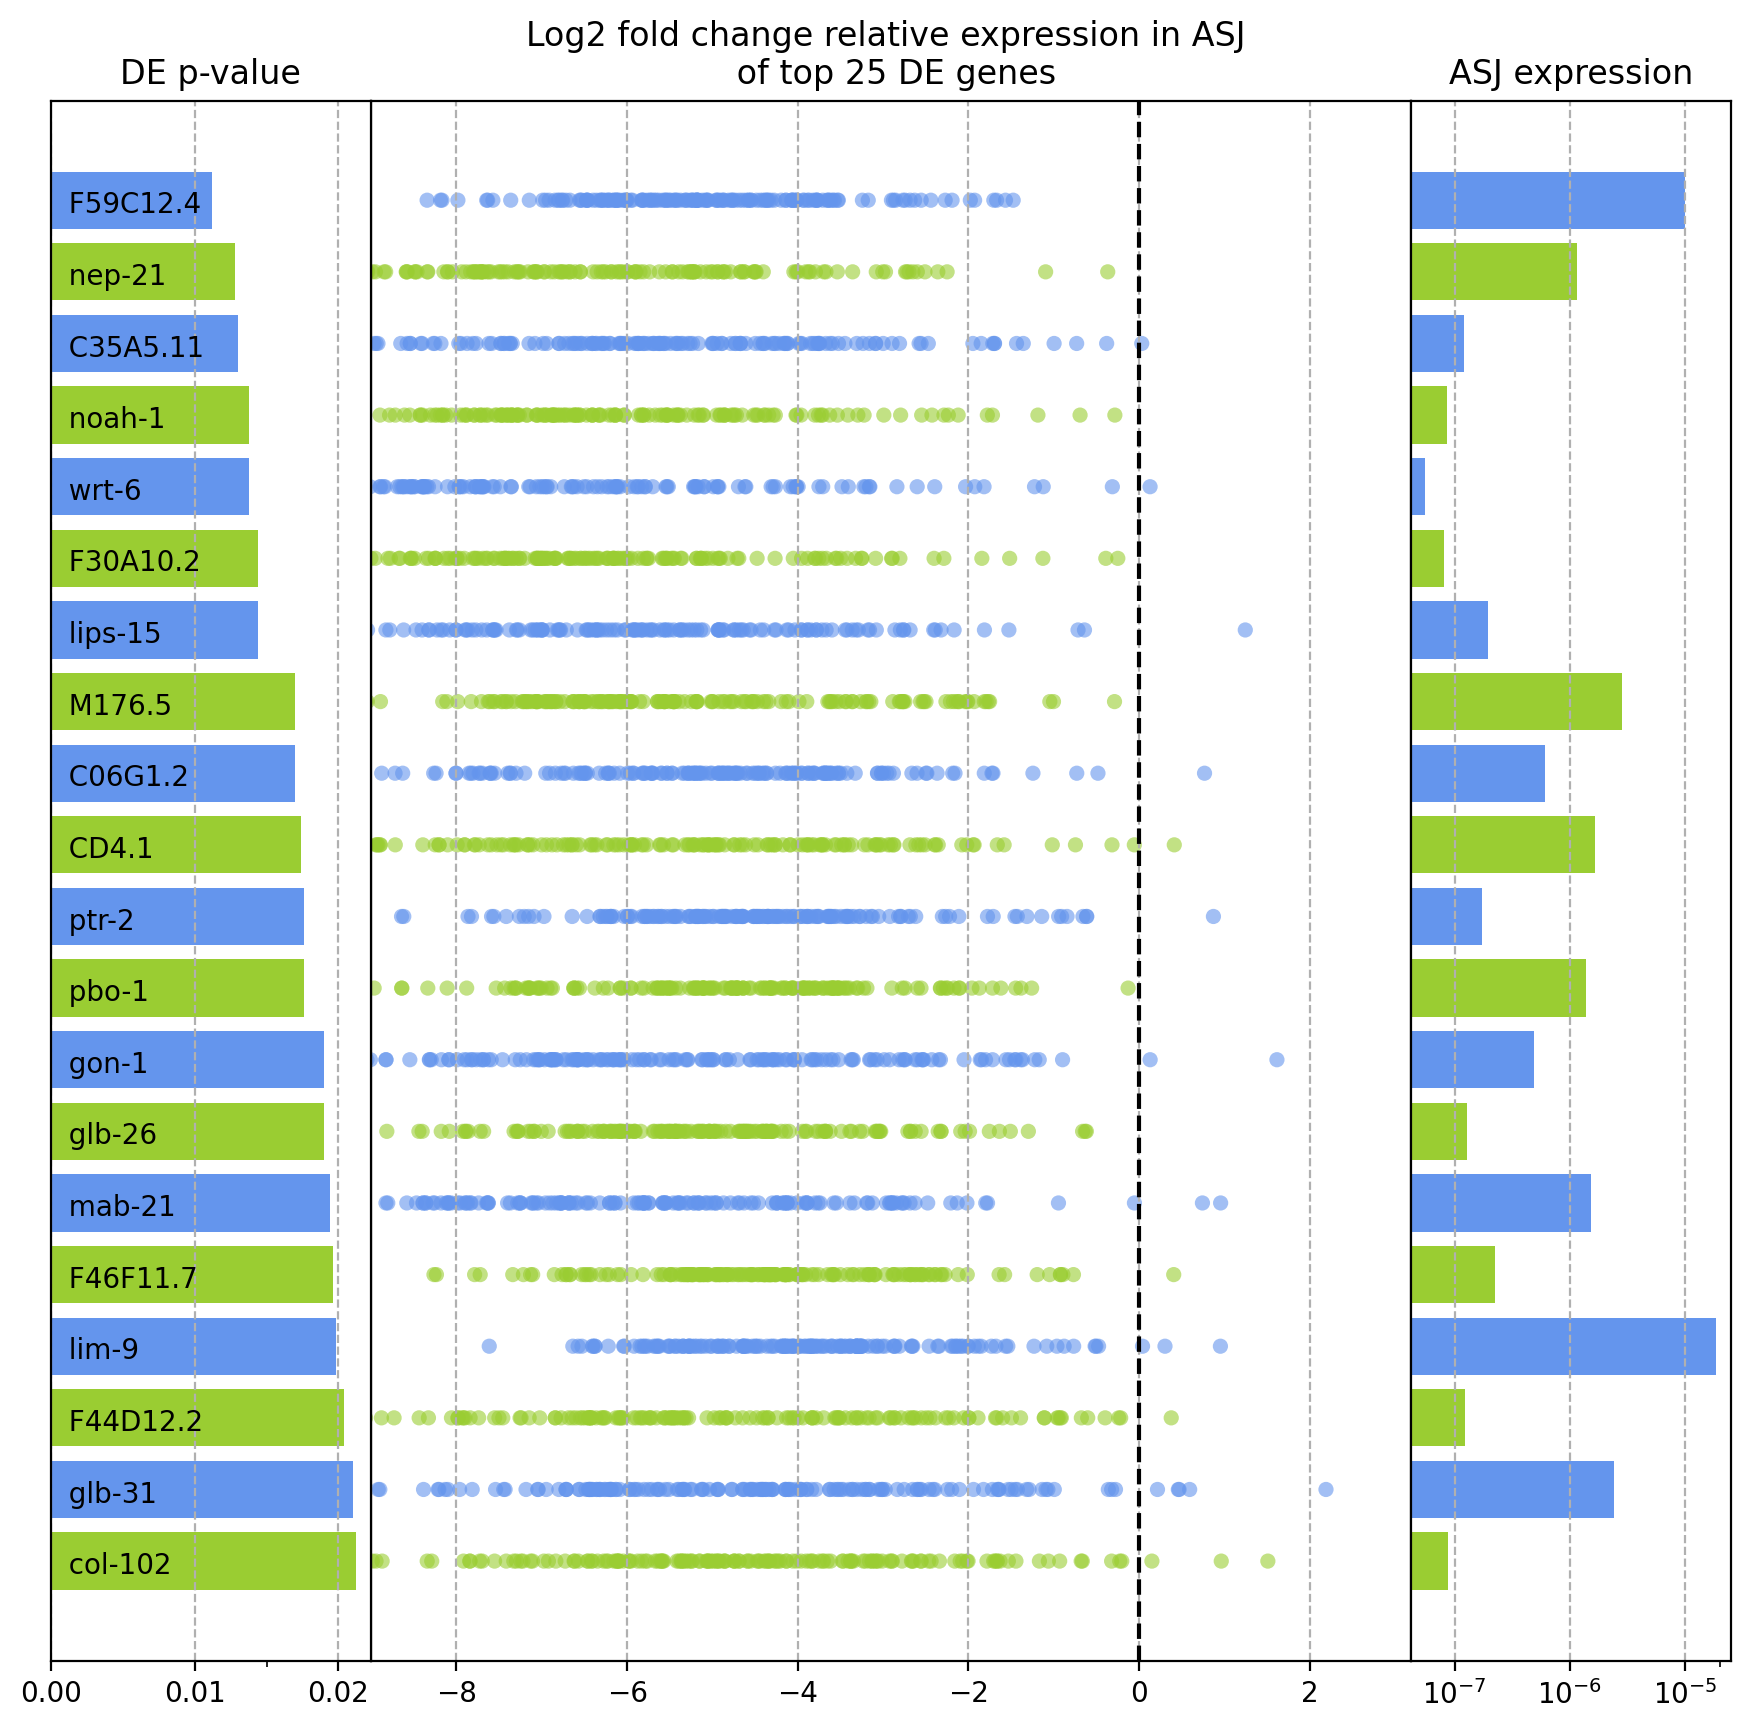

ASK


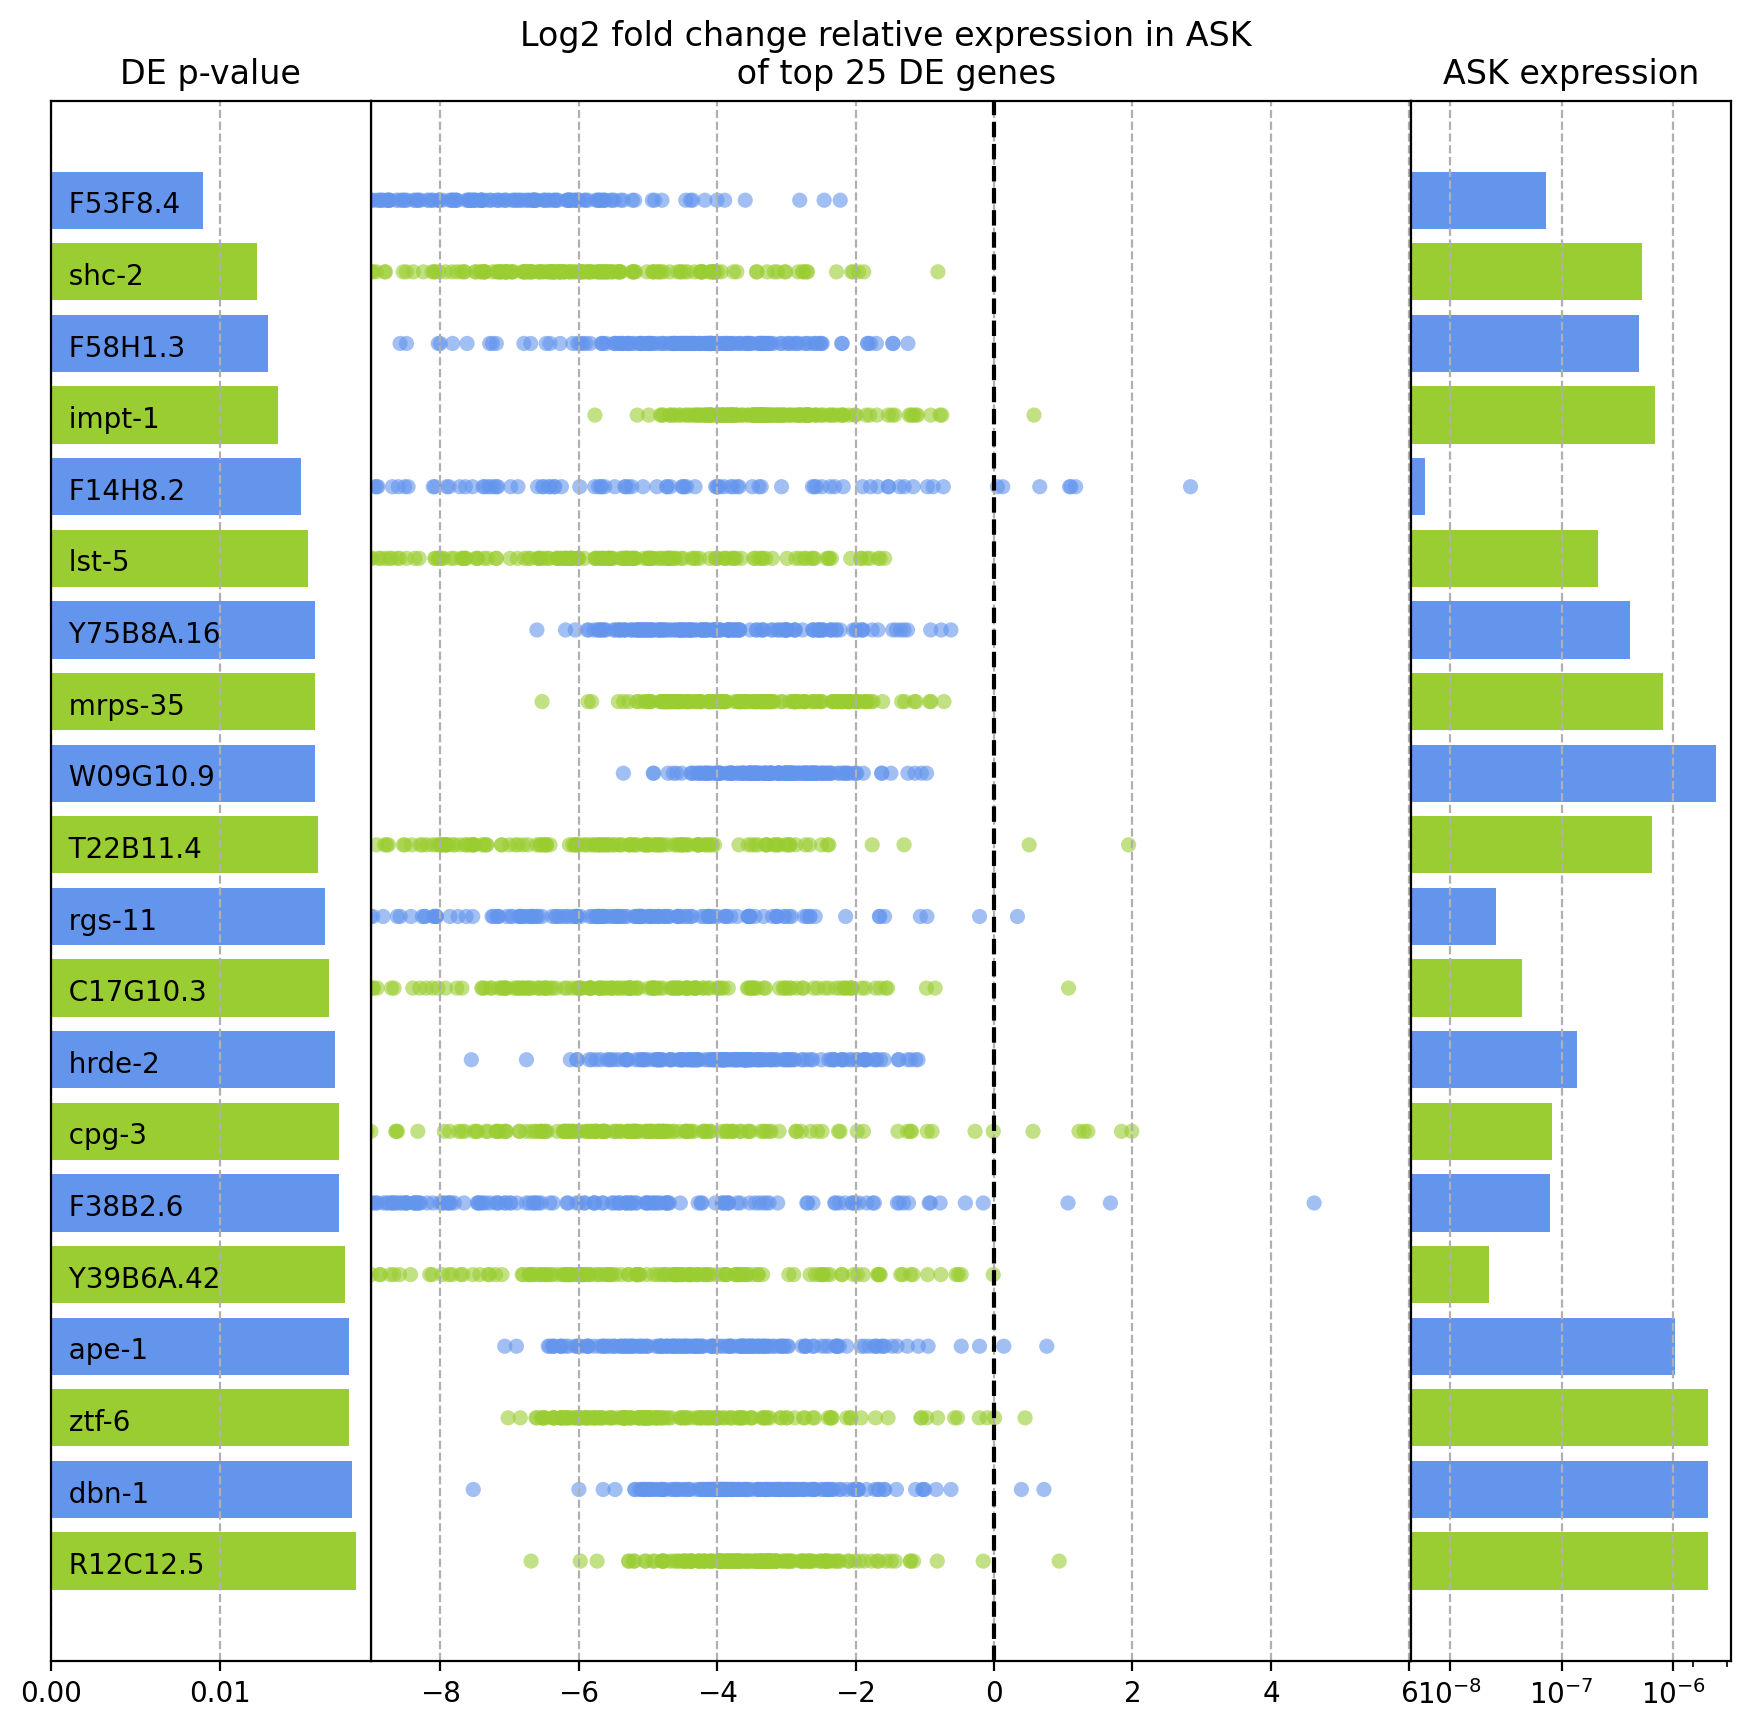

ADF


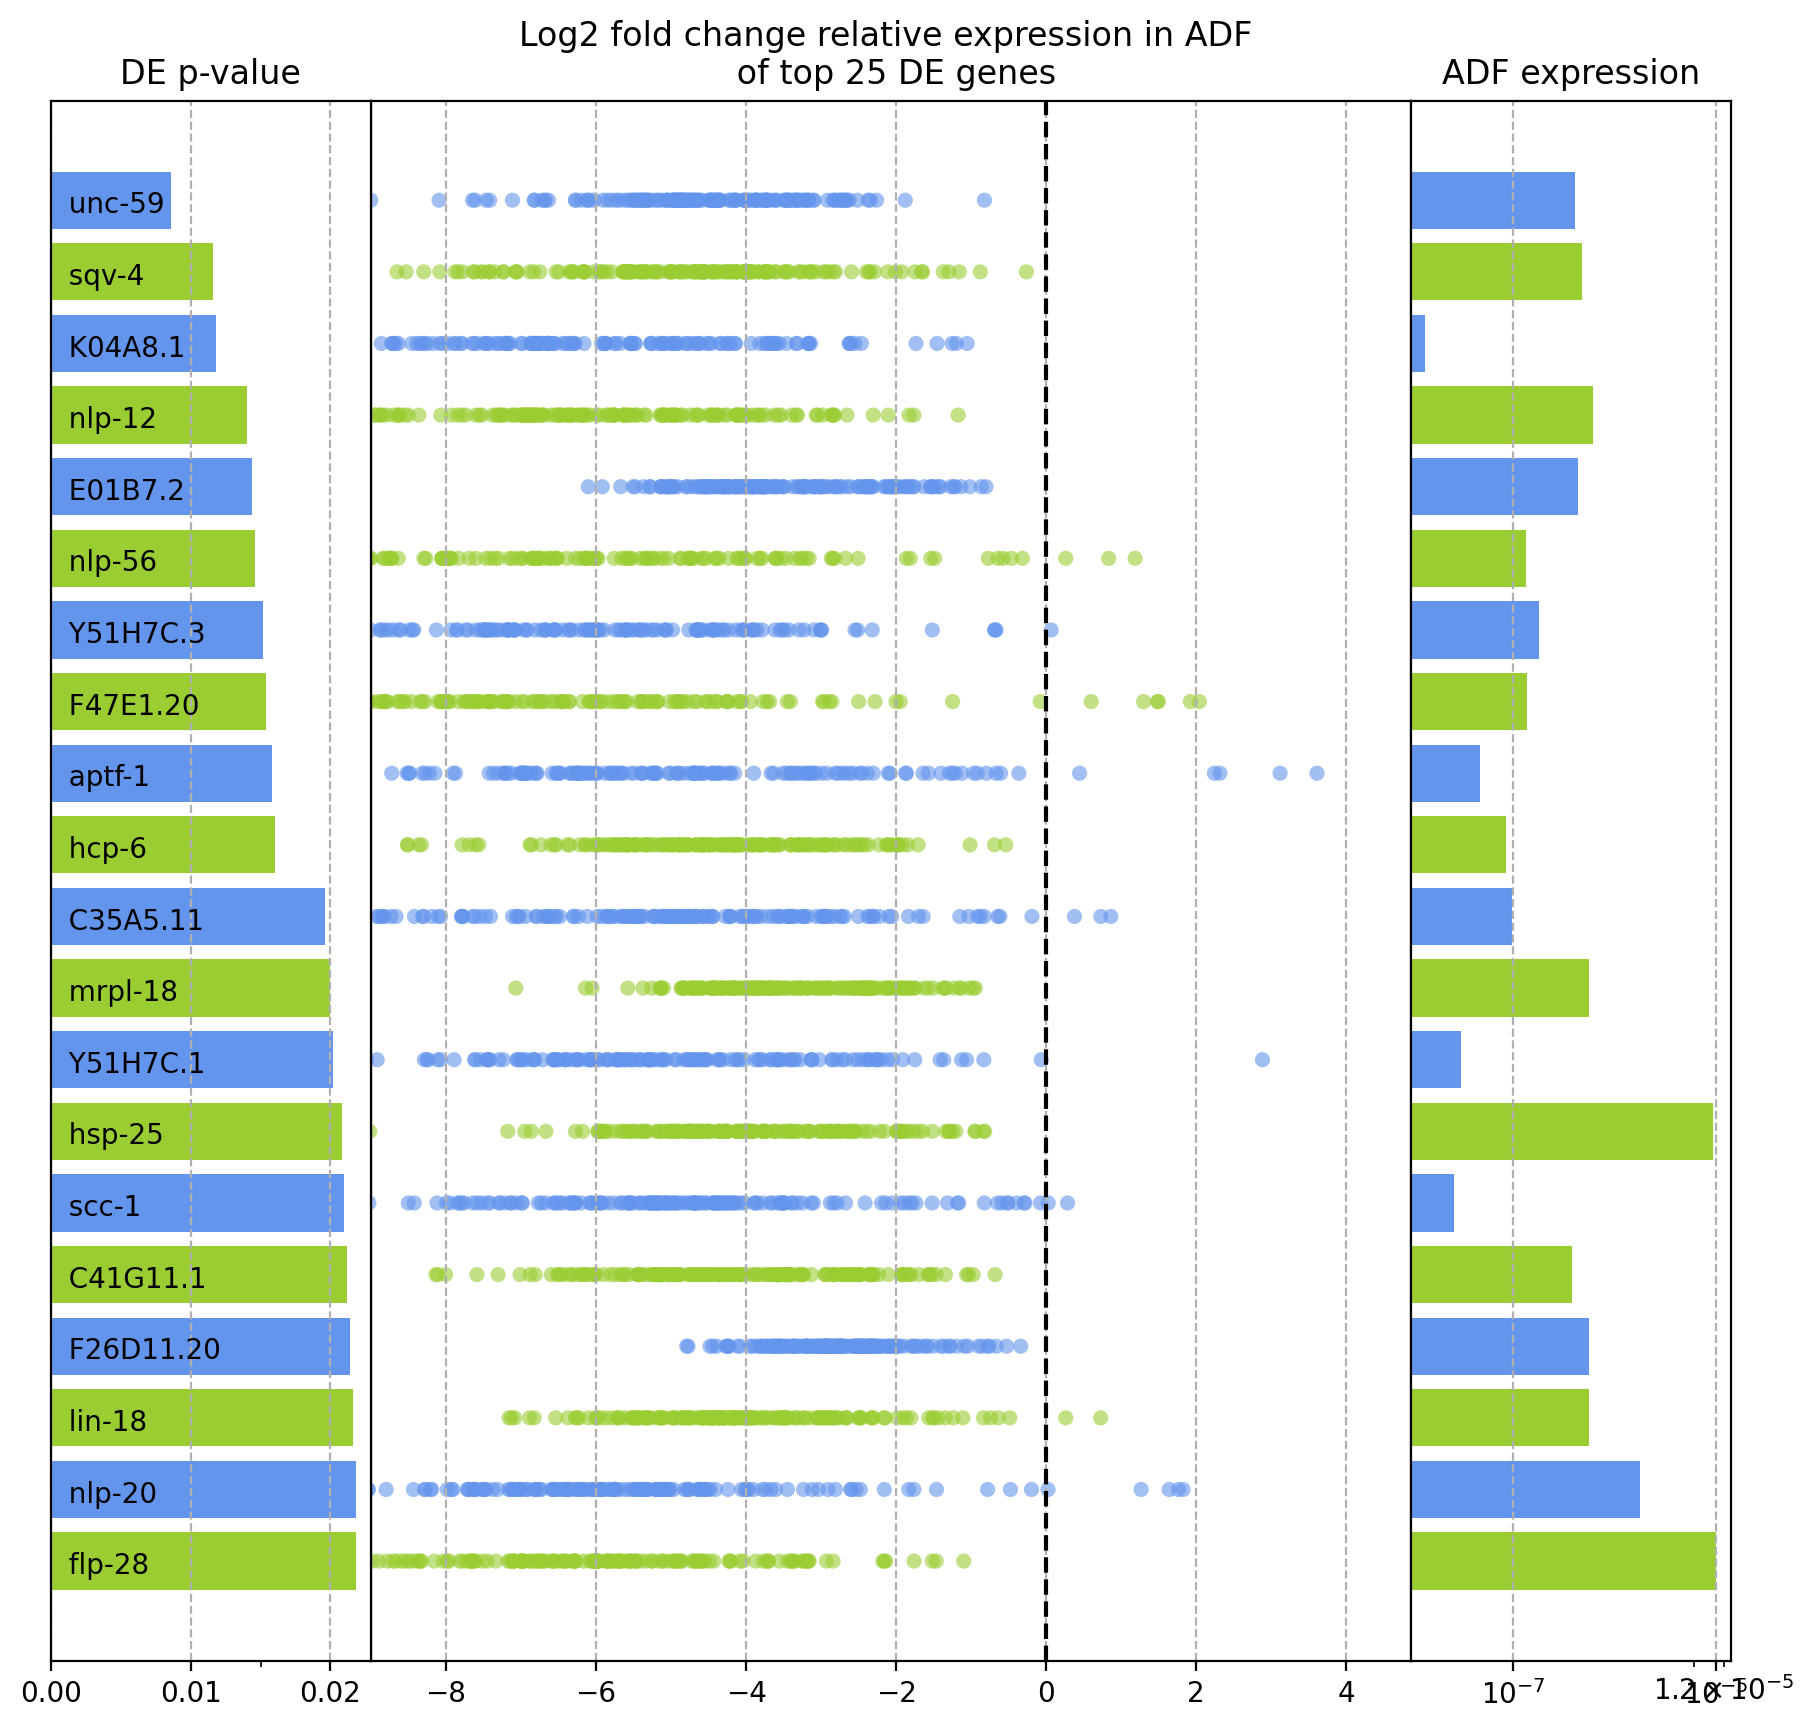

ADL


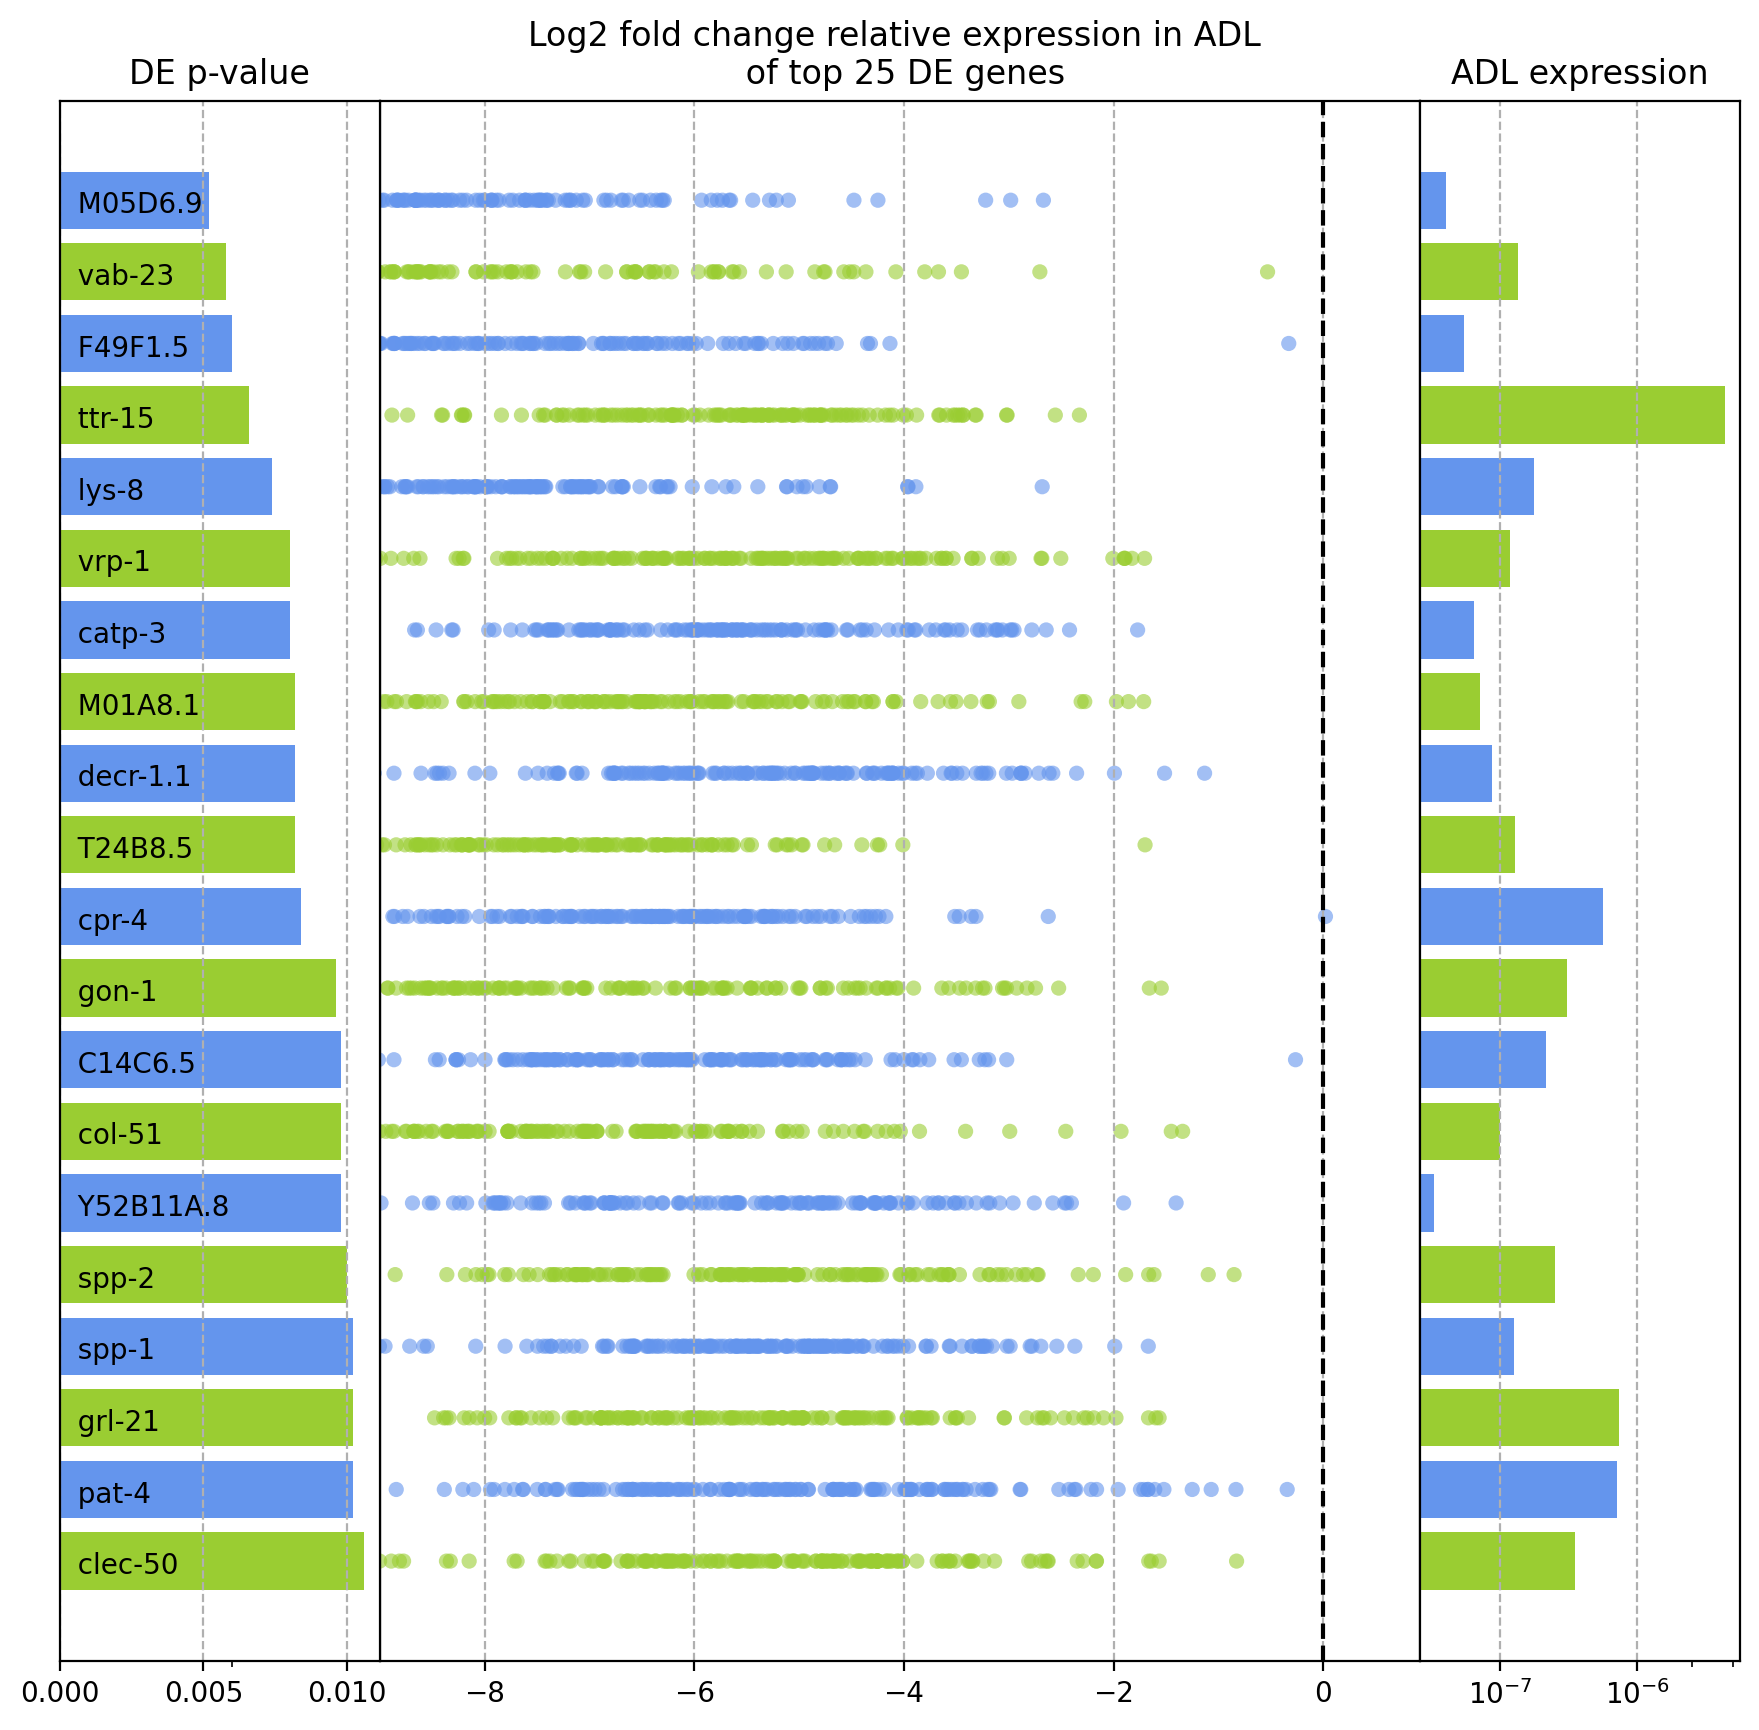

AWA


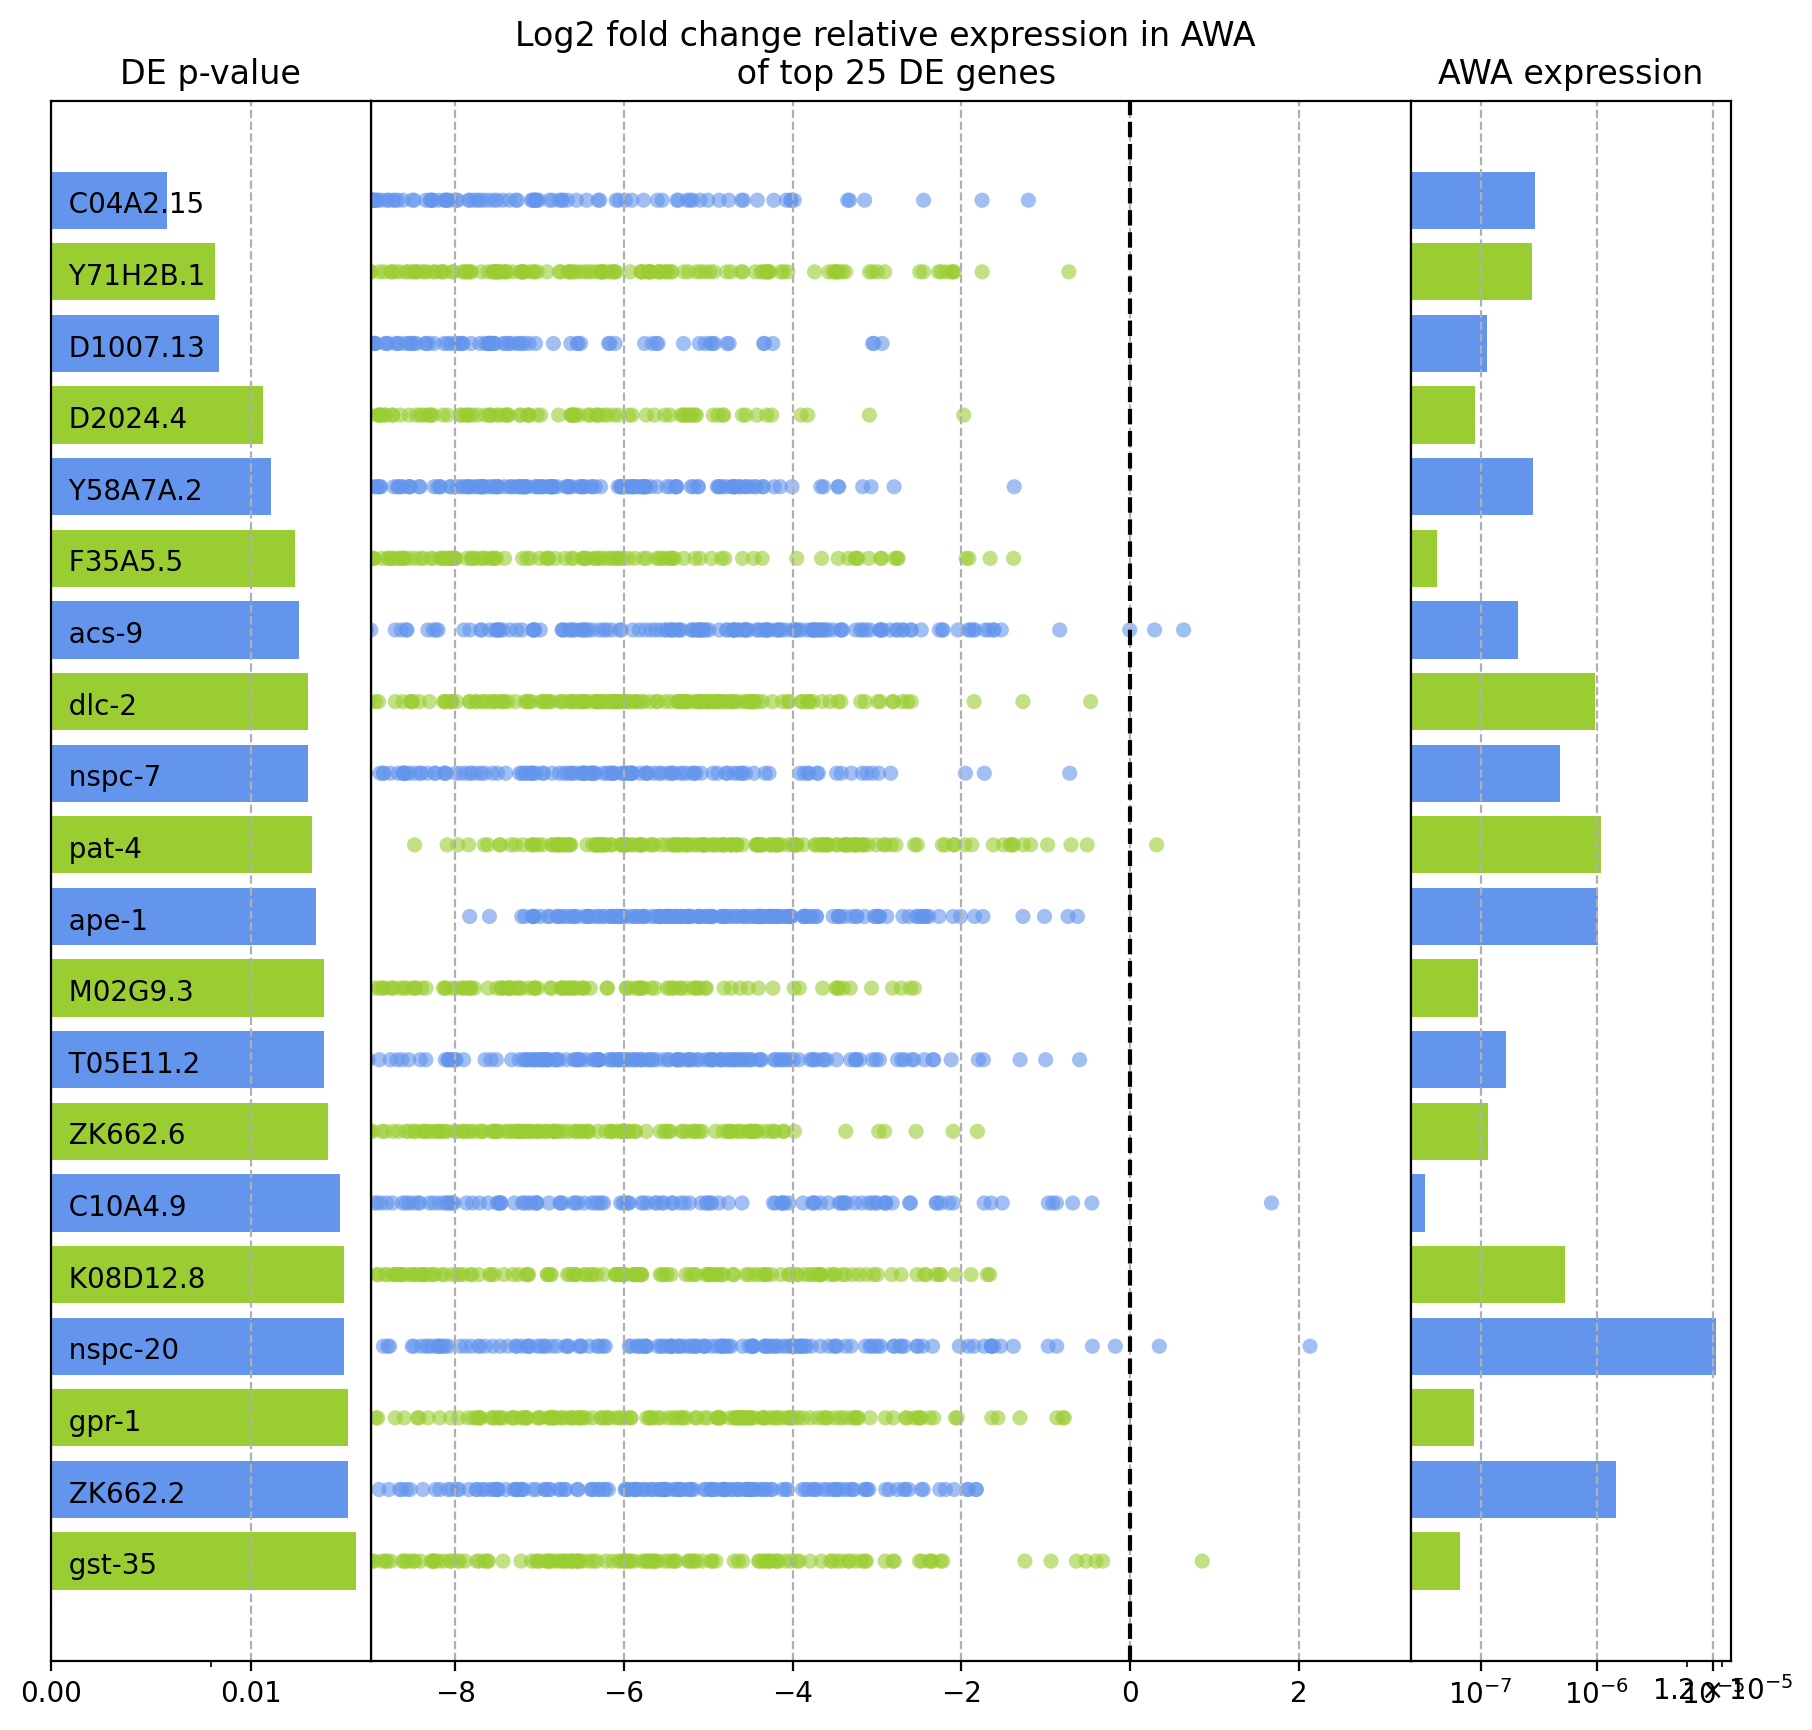

AWB


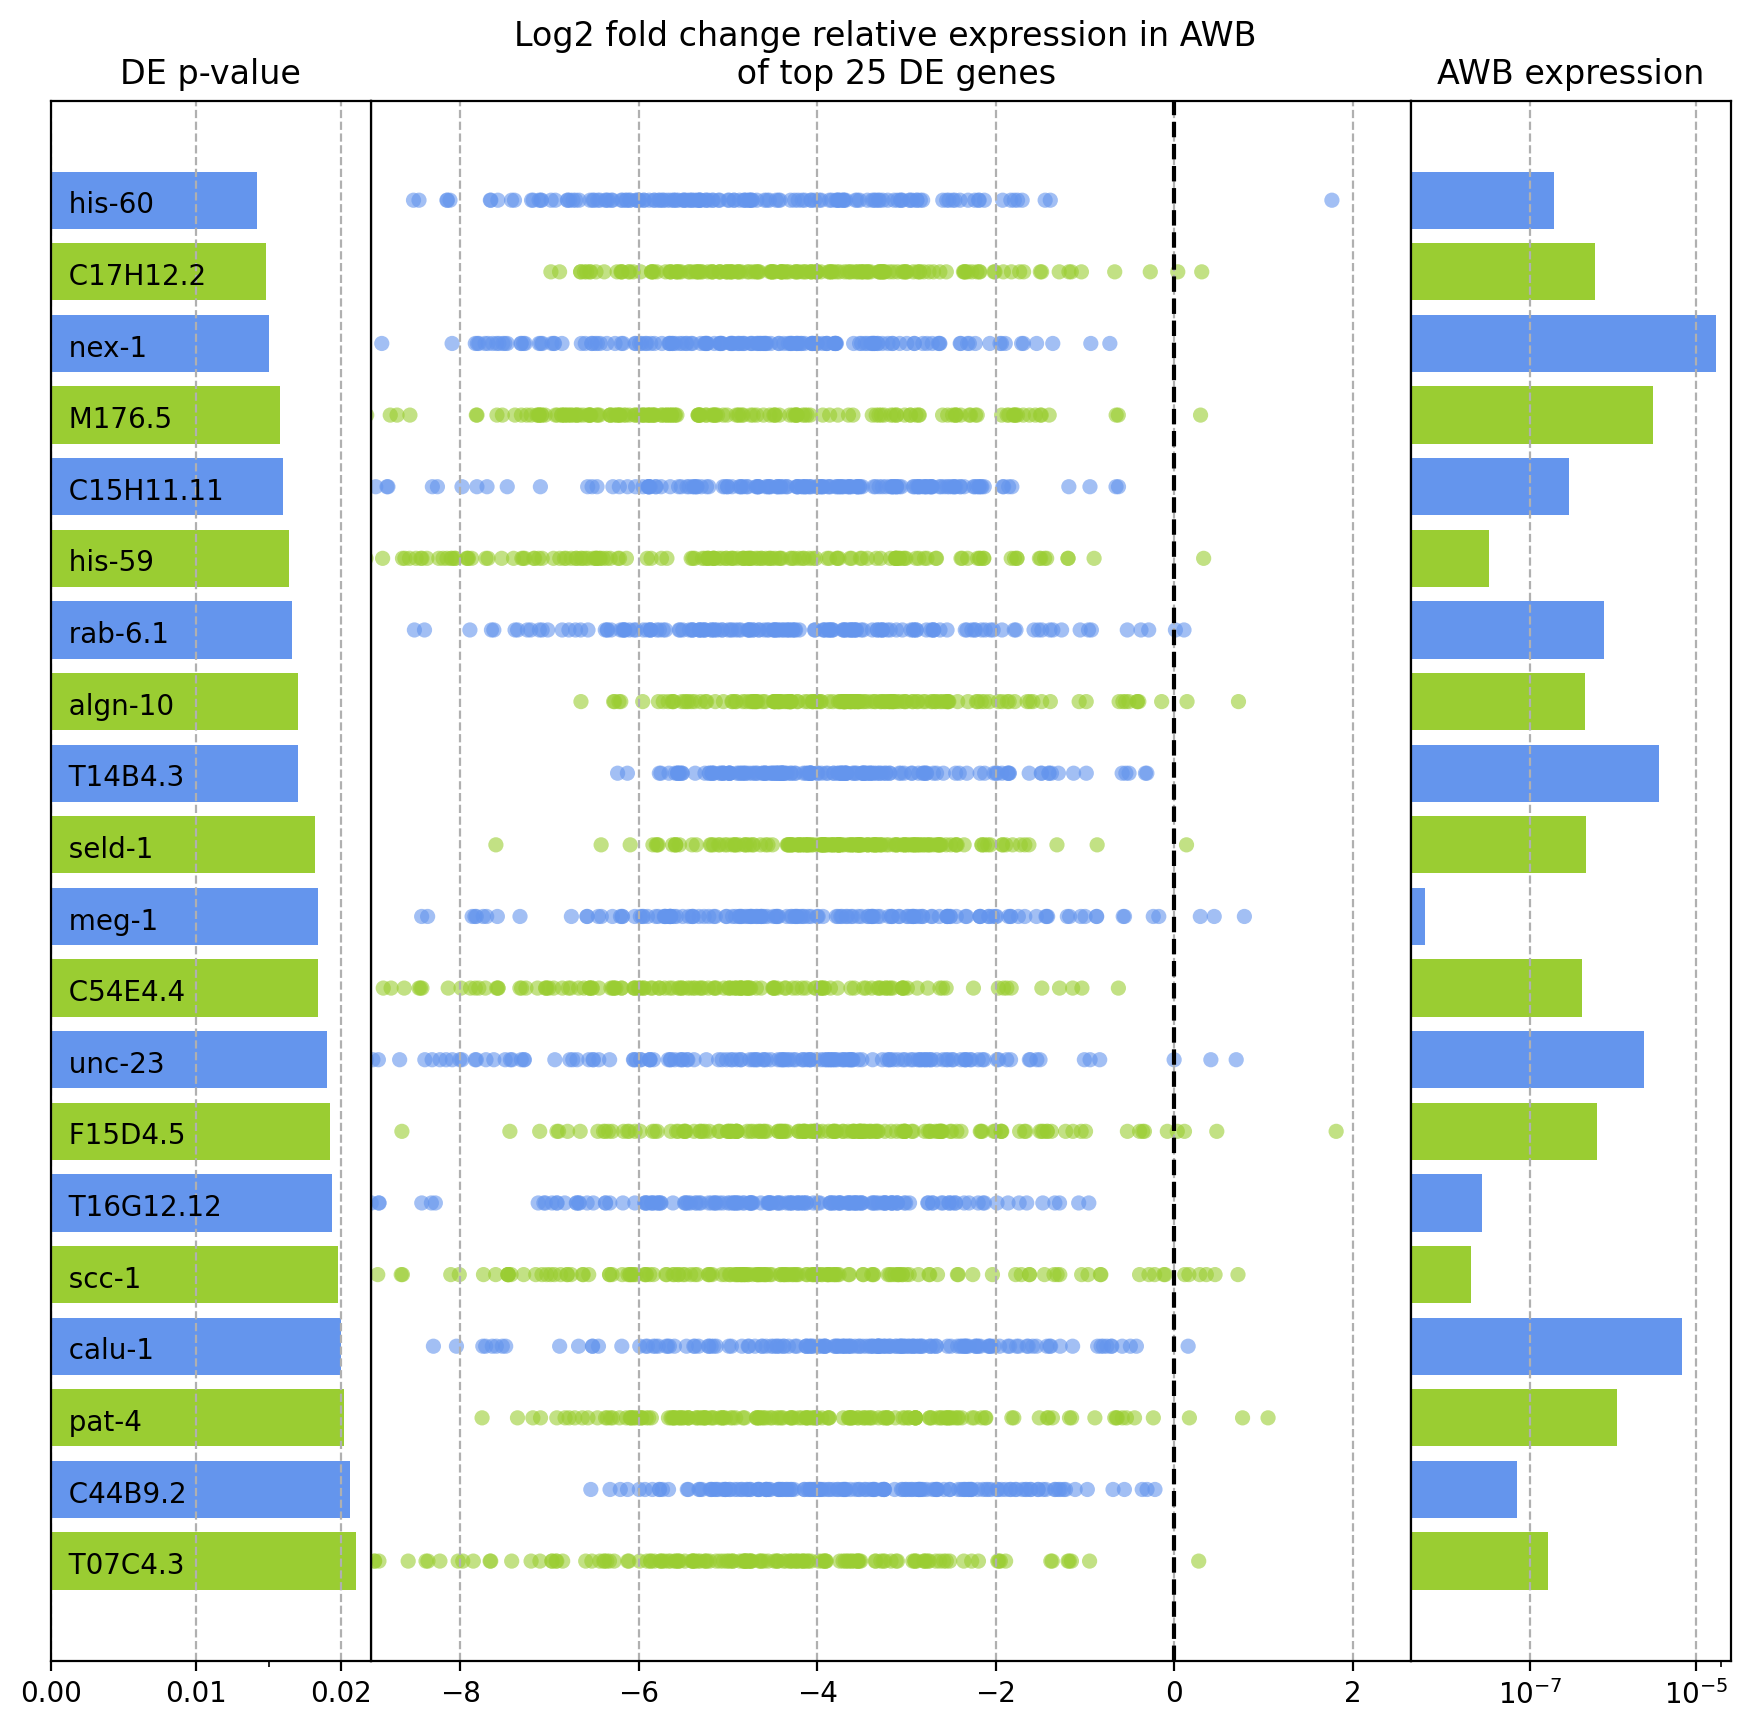

AWC_ON


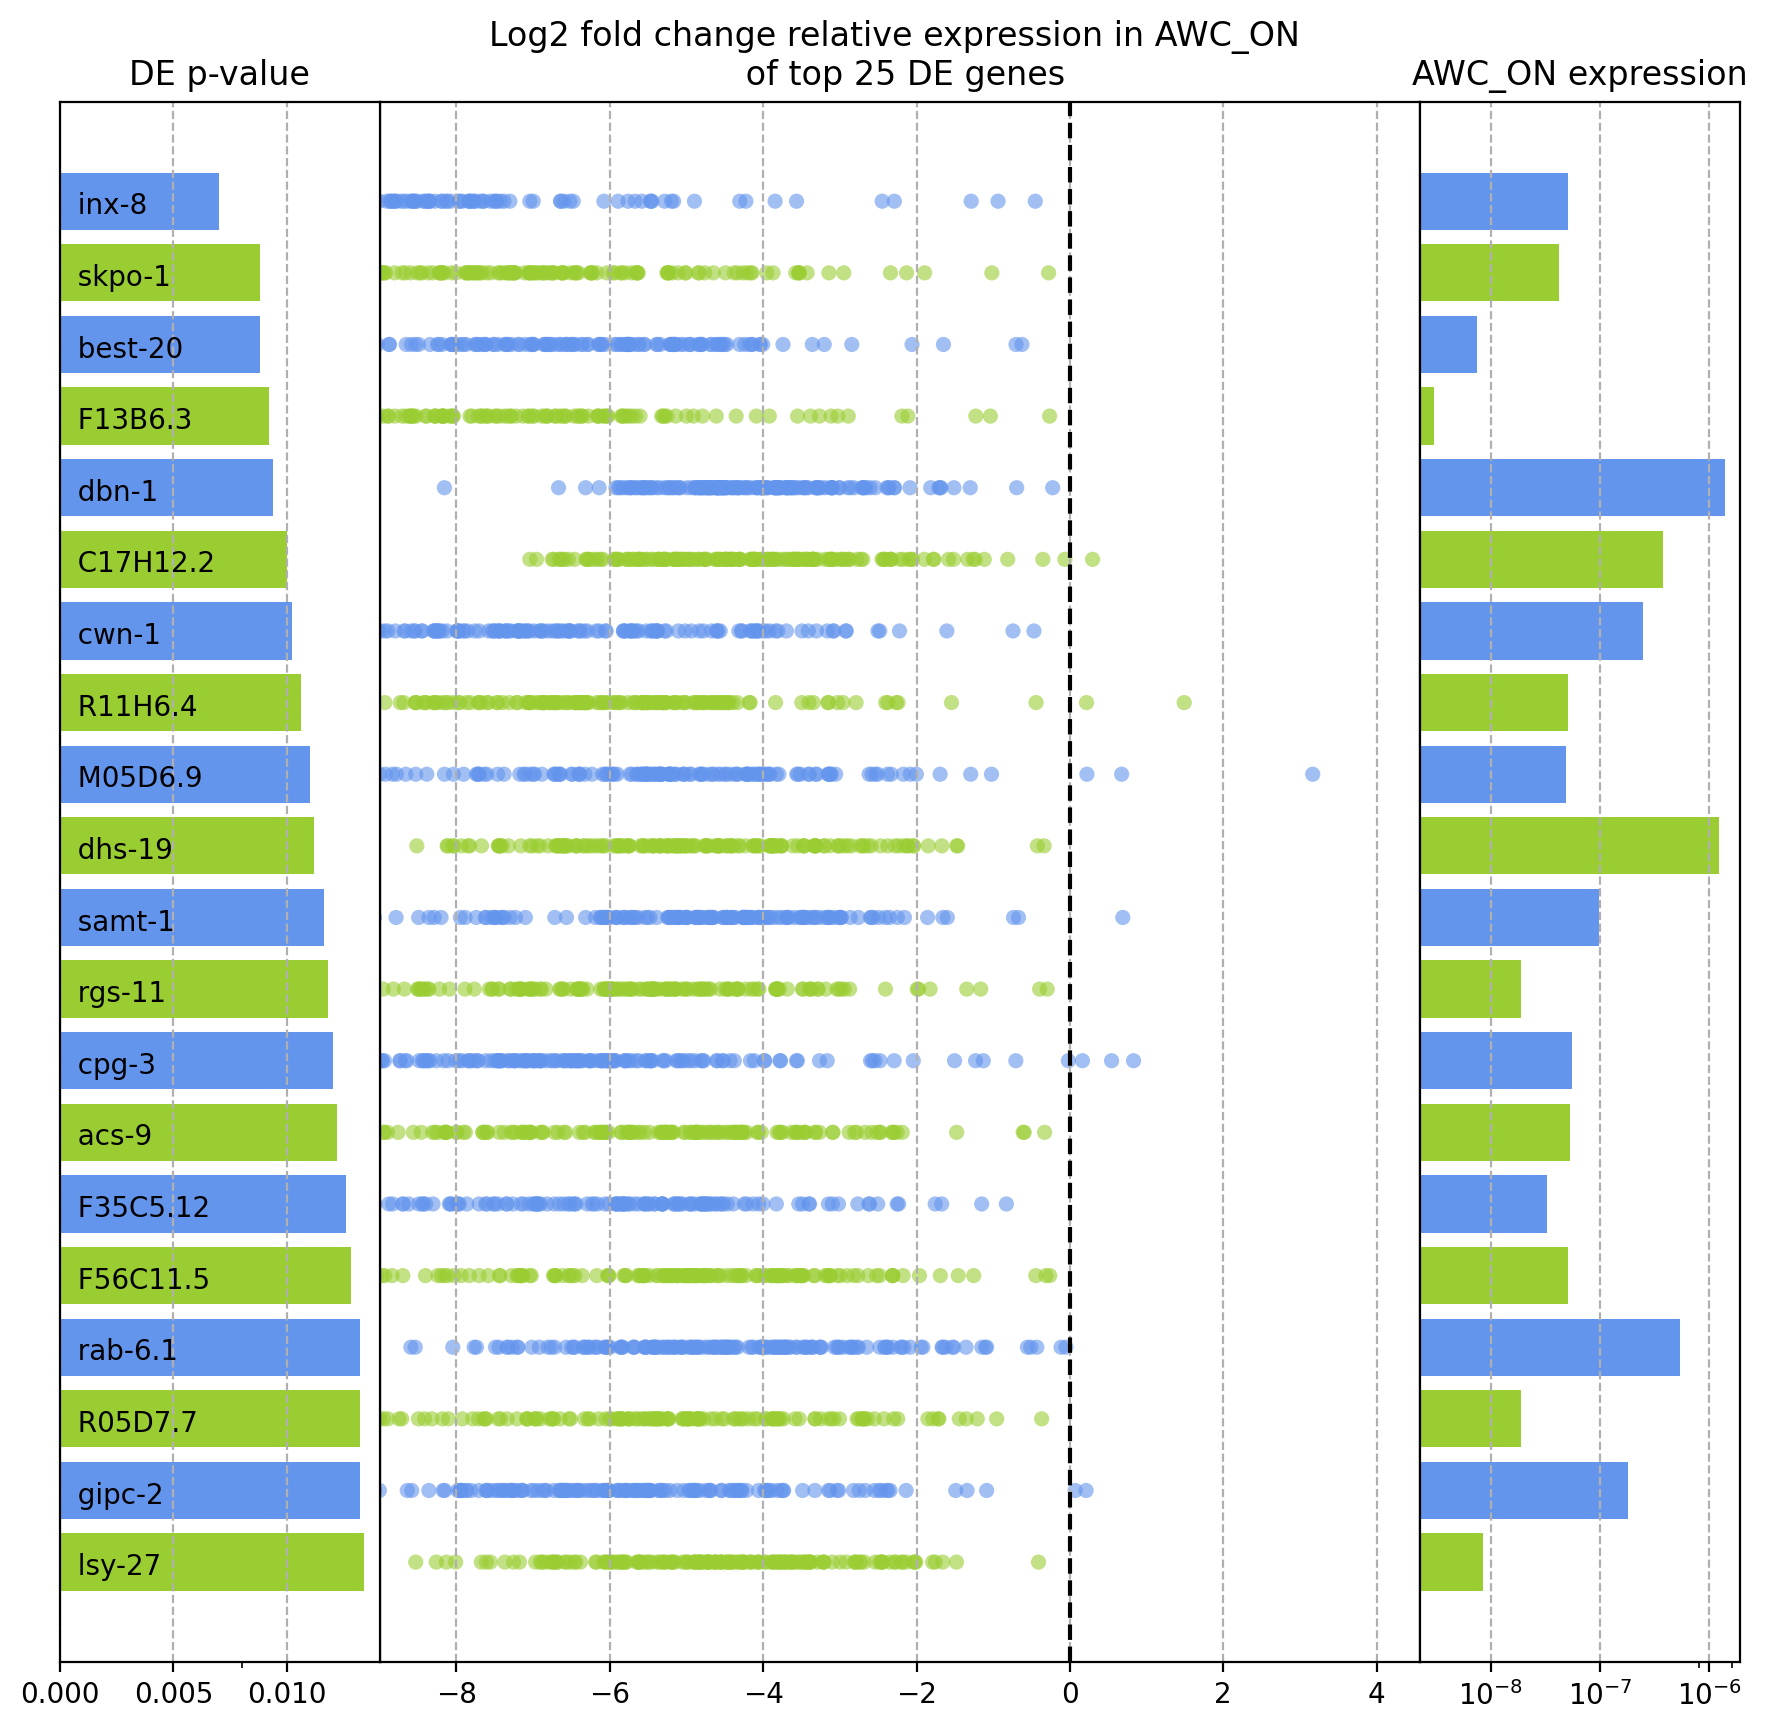

AWC_OFF


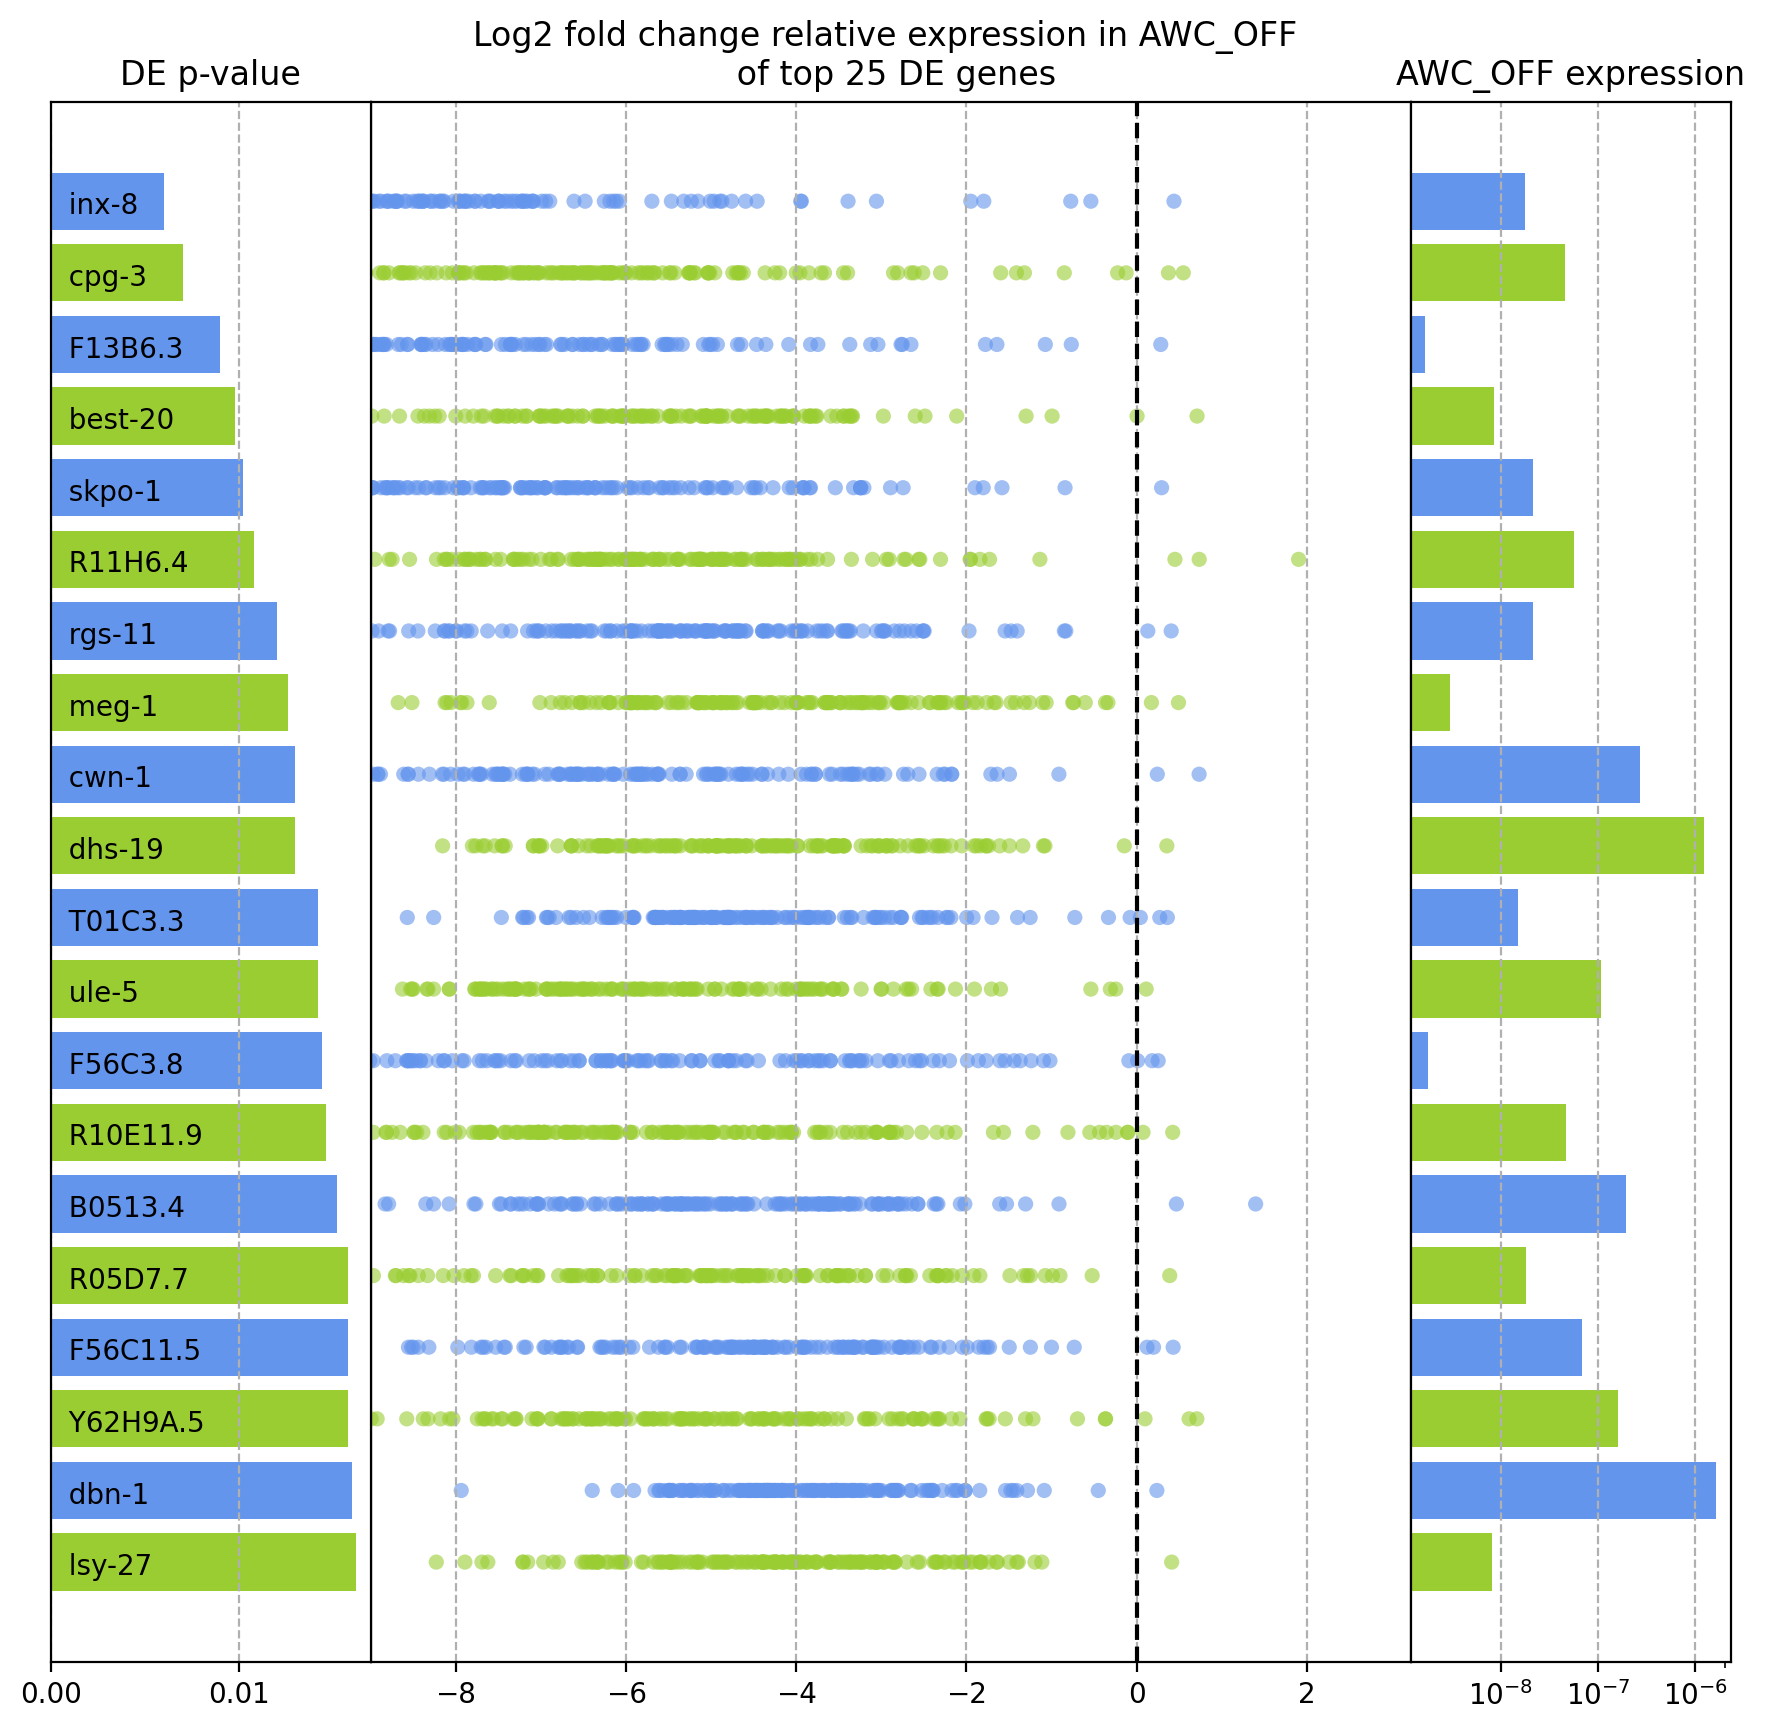

AFD


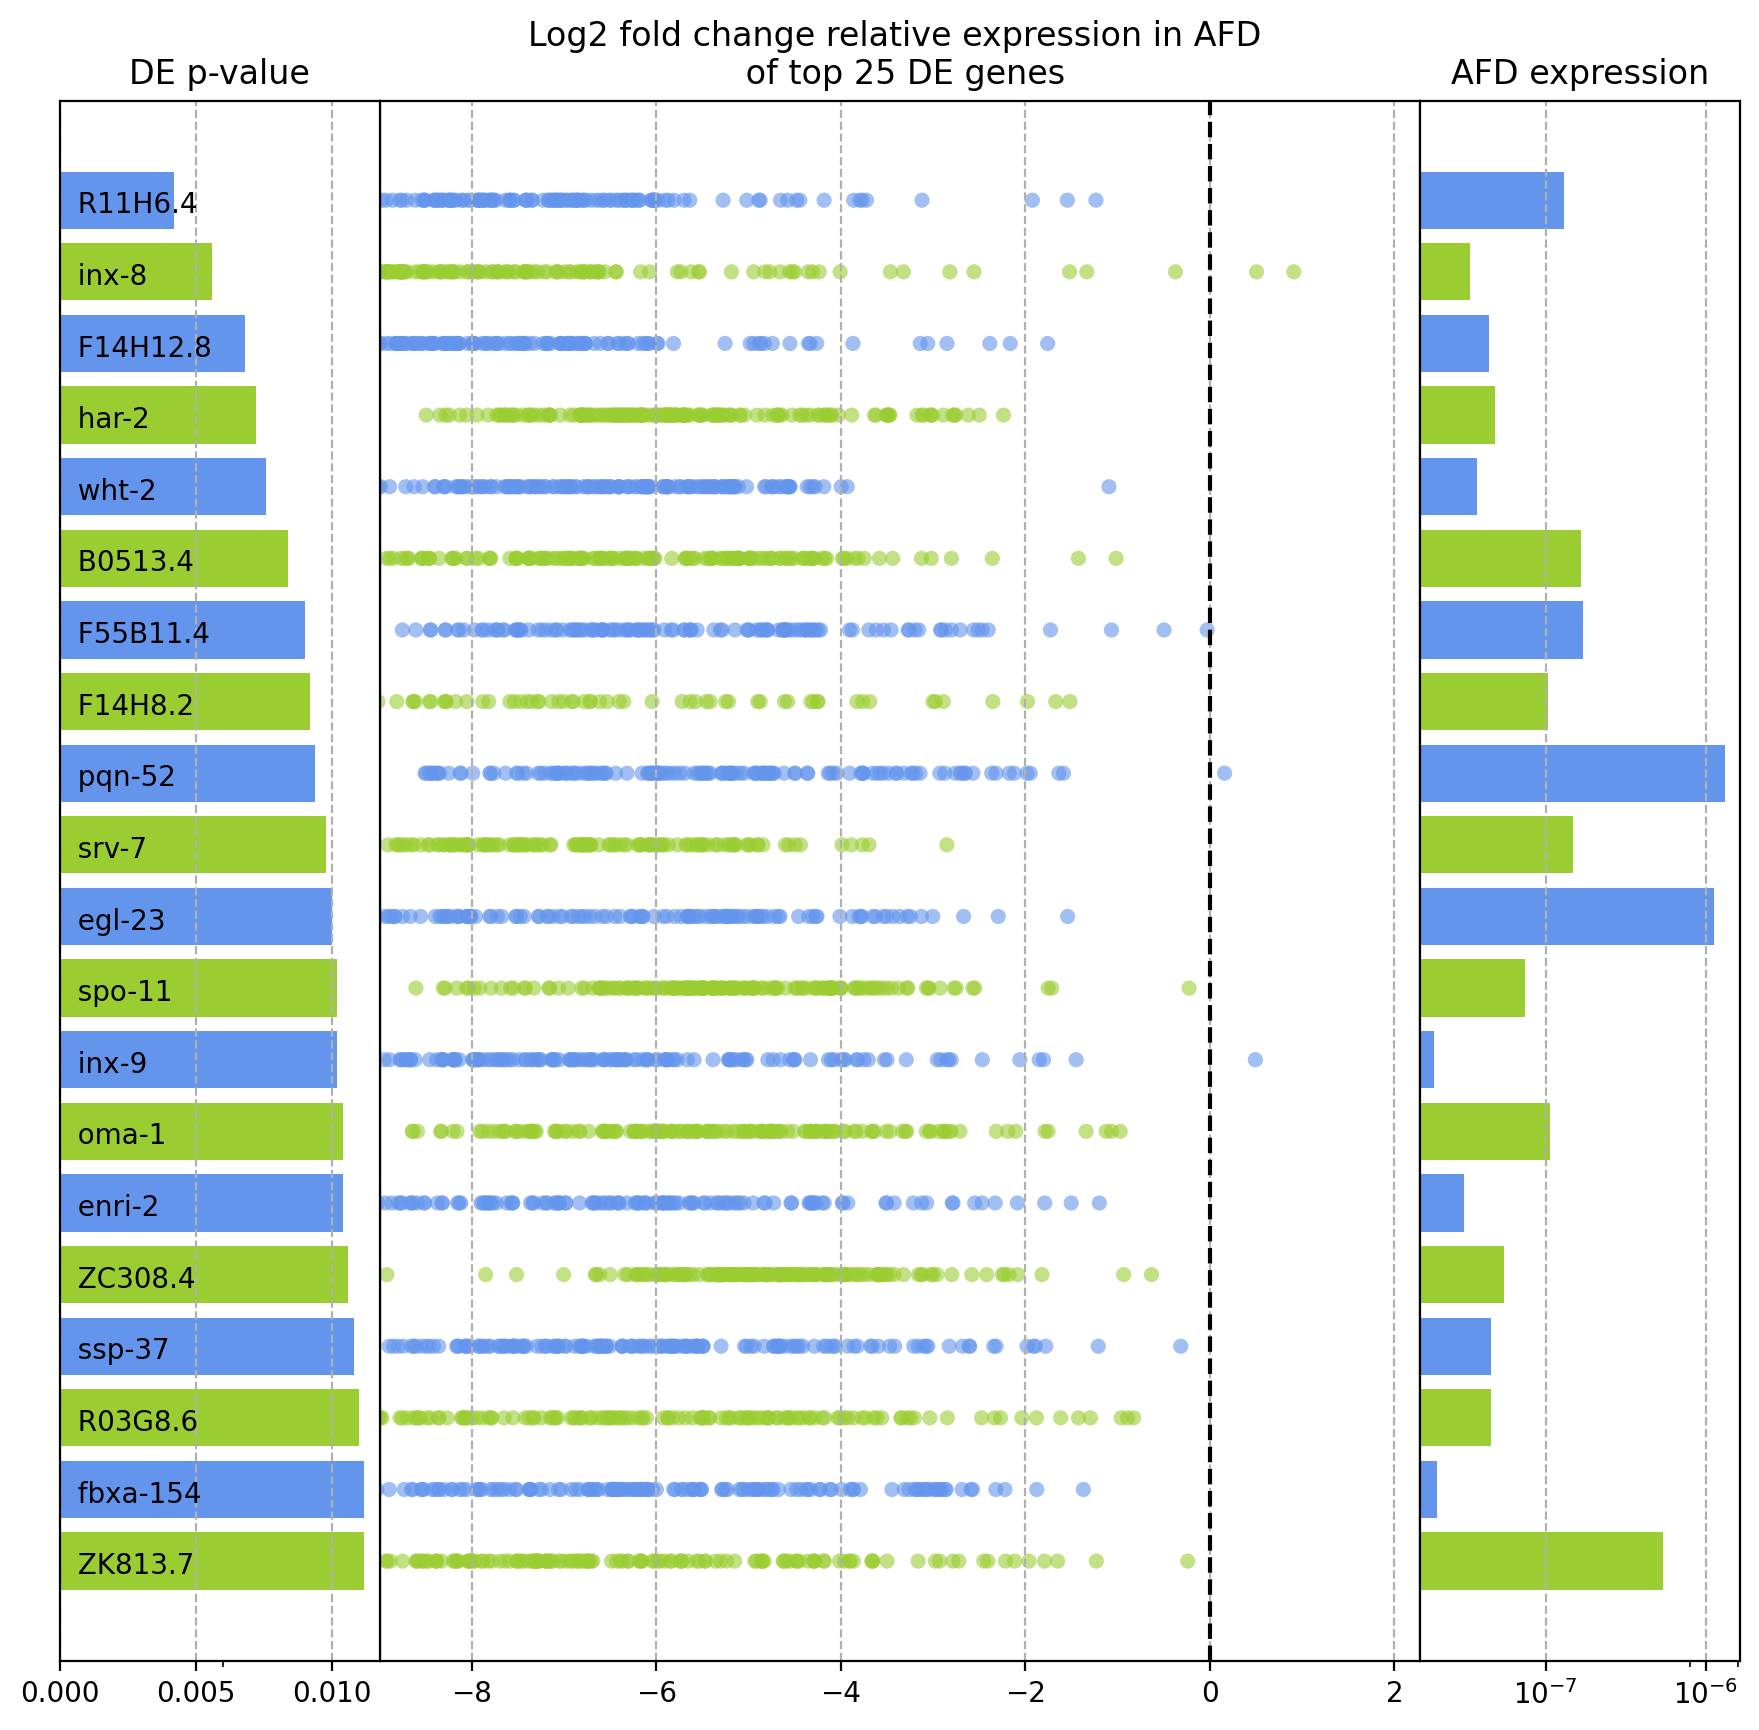

In [319]:
cells_of_interest=['ASEL','ASER','ASG','ASH','ASI','ASJ','ASK','ADF','ADL','AWA','AWB','AWC_ON','AWC_OFF','AFD']

for celltype in cells_of_interest:
    print(celltype)

    topde=pd.read_csv('globalde'+celltype+'taylor2020.csv')
    topde

    colors = itertools.cycle(["yellowgreen", 'cornflowerblue'])


    n_genes_selected=25

    global_de=pd.read_csv('globalde'+celltype+'taylor2020.csv')
    # select only negative logfold change genes
    negative_lfc_genes=global_de[global_de['lfc_mean']<0]
    #within negative lfc genes, sort by p value, then reindex them with lowest p value being ranked first 
    topgenes=negative_lfc_genes.sort_values(by='proba_not_de')['gene_id'][:ntop].iloc[::-1].reset_index(drop=True)
    topgenes.index += 1 
    topgenes

    pairwise_de=pd.read_csv('DE_results_'+celltype+'_taylor2020.csv', )
    pairwise_de
    pairwise_de_selection
    pairwise_de_selection = pairwise_de[pairwise_de['gene_id'].isin(topgenes)]
    pairwise_de_selection

    de_topgenes=global_de[global_de['gene_id'].isin(topgenes)]

    # definitions for the axes
    left, width = 0.1, 0.65
    bottom, height = 0.1, 0.65
    spacing = 0.0

    rect_scatter = [left, bottom, width, height]
    rect_left = [ -left  + spacing, bottom, 0.2, height]
    rect_right = [left + width + spacing, bottom, 0.2, height]

    # start with a square Figure
    fig = plt.figure(figsize=(8, 12), dpi=100)

    ax = fig.add_axes(rect_scatter)
    ax_left = fig.add_axes(rect_left, sharey=ax)
    ax_right = fig.add_axes(rect_right, sharey=ax)

    ax.axes.yaxis.set_visible(False)
    ax_left.axes.yaxis.set_visible(False)
    ax_right.axes.yaxis.set_visible(False)


    for rank, gene_id in topgenes.iteritems():
        color=next(colors)
        gene_expression_values = pairwise_de_selection[pairwise_de_selection['gene_id']==gene_id]
        ax.scatter(gene_expression_values['lfc_mean'], [rank]*len(gene_expression_values), c=color, alpha=0.6, s = 30, edgecolors='none')
        expression=de_topgenes.query('gene_id==@gene_id')['scale1'].values
        pvalue=de_topgenes.query('gene_id==@gene_id')['proba_not_de'].values
        ax_right.barh(rank,expression , color=color)
        ax_left.barh(rank,pvalue , color=color)
        ax_left.text(0, rank-0.18,'  '+ genemaps.loc[gene_id][0])
    #     ax_right.text(ax_right.get_xlim()[0], rank,' foo')

    ax.title.set_text('Log2 fold change relative expression in ' +celltype +' \n of top '+ str(n_genes_selected) + ' DE genes')
    ax_left.title.set_text('DE p-value')
    ax_right.title.set_text(celltype + ' expression')

    ax_left.grid(True, ls = '--')
    ax_right.grid(True, ls = '--')
    # ax_left.set_xscale('log')
    ax_right.set_xscale('log')
    ax.set_xlim(left=-9)
    # ax.set_xlabel('Log2 fold change relative to cell expression in ' +celltype)
    # ax_left.set_xlabel('common label')
    # ax_right.set_xlabel('common label')
    # ax_left.xaxis.set_major_locator(plt.MaxNLocator(1))
    # ax_right.xaxis.set_major_locator(plt.MaxNLocator(1))
    ax_left.xaxis.set_minor_locator(plt.MaxNLocator(2))
    ax_right.xaxis.set_minor_locator(plt.MaxNLocator(2))

    ax.grid(True, ls = '--')
    ax.axvline(x=0, color='k', linestyle='--')
    plt.savefig('./niceplots/'+celltype+'_nice_swarmplot.png', dpi=150)
    plt.show()